## DONALD TRUMP TWEETS ANALYSIS

Data Source : https://www.thetrumparchive.com/

### Scraping the website for tweets

In [1]:
!pip install selenium
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [2]:
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from collections import Counter
from scipy.stats import zipf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
from numpy.linalg import norm
from math import log
import numpy as np
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment  import  SentimentIntensityAnalyzer
stopwords = stopwords.words('english')

In [3]:
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

wd = webdriver.Chrome('C:/Users/HP/Downloads/chromedriver_win32/chromedriver',options=chrome_options)
wd.get('https://www.thetrumparchive.com/')


In [4]:
## Extract the retweets, likes, dates of the different tweets
def extractDetails(tweetElements,tweetDetailsDf):
    print('Extracting details for {} tweets'.format(len(tweetElements)))
    for index,tweet in enumerate(tweetElements):
        wasDeleted=False
        date = tweet.find_element(by=By.CLASS_NAME,value='date___1q2oK')
        date_time = re.sub(' EST$','',re.sub('(\d+)th|rd|st|nd','\g<1>',date.text))
        dateObject = datetime.strptime(date_time,'%b %d %Y - %I:%M:%S %p')
        details = tweet.find_element(by=By.CLASS_NAME,value='icons___3WEom')
        retweets = details.find_elements(by=By.TAG_NAME,value='span')[0].text
        likes = details.find_elements(by=By.TAG_NAME,value='span')[1].text
        delete = details.find_elements(by=By.TAG_NAME,value='span')[2].text
        if(delete=='Deleted'): ## Check if the tweet was deleted by Twitter
            wasDeleted=True
        tweet = tweet.find_element(by=By.CLASS_NAME,value='text___k4s4q.plain___1AdbJ').text
        print("Row index {}".format(index))
        tweetDetailsDf.loc[len(tweetDetailsDf)] = [dateObject,retweets,likes,tweet,wasDeleted]
    return tweetDetailsDf

    

In [7]:
# Crawl the tweets from the webpage for a particular time period
import re
import time
from datetime import datetime,date
from dateutil.relativedelta import relativedelta

def crawler(dateFrom,dateTo,tweetDetailsDf):
    while dateFrom>=date(2009,1,1):
        mainUrl = 'https://www.thetrumparchive.com/?dates=%5B%22{}%22%2C%22{}%22%5D'.format(dateFrom,dateTo)
        print("Extracting tweets from {}".format(mainUrl))
        wd.get(mainUrl)
        time.sleep(0.5)
        end = False
        tableElement = wd.find_element(by=By.CLASS_NAME,value='list___2uPLh')
        temp = tableElement.find_element(by=By.CLASS_NAME,value='css-145p3ou.e1hwwpu60')
        tweetNumbersText= temp.find_elements(by=By.TAG_NAME,value='span')
        tweetNumber = int(tweetNumbersText[0].text.replace(',',''))
        print("Tweets between {} and {} are {}".format(dateFrom,dateTo,tweetNumber))
        while end==False:
            tweetElements = tableElement.find_elements(by=By.CLASS_NAME,value='tweet___2xXtA.ttaTweet')
            wd.execute_script("return arguments[0].scrollIntoView();", tweetElements[-1])
            time.sleep(0.8)
            print(len(tweetElements))
            if(len(tweetElements)==tweetNumber):
                end=True
        tweetDetailsDf = extractDetails(tweetElements,tweetDetailsDf)
        dateTo = dateFrom-relativedelta(days=1)
        dateFrom = dateFrom-relativedelta(months=4)
        print("New dateFrom : {}".format(dateFrom))
        print("New dateTo : {}".format(dateTo))
    return tweetDetailsDf

In [8]:
tweetDetailsDf = pd.DataFrame(columns=['Date','Retweets','Likes','Tweet','WasDeleted'])
resultsDf = crawler(date(2009,1,1),date(2010,1,1),tweetDetailsDf)

Extracting tweets from https://www.thetrumparchive.com/?dates=%5B%222009-01-01%22%2C%222010-01-01%22%5D
Tweets between 2009-01-01 and 2010-01-01 are 56
25
50
56
Extracting details for 56 tweets
Row index 0
Row index 1
Row index 2
Row index 3
Row index 4
Row index 5
Row index 6
Row index 7
Row index 8
Row index 9
Row index 10
Row index 11
Row index 12
Row index 13
Row index 14
Row index 15
Row index 16
Row index 17
Row index 18
Row index 19
Row index 20
Row index 21
Row index 22
Row index 23
Row index 24
Row index 25
Row index 26
Row index 27
Row index 28
Row index 29
Row index 30
Row index 31
Row index 32
Row index 33
Row index 34
Row index 35
Row index 36
Row index 37
Row index 38
Row index 39
Row index 40
Row index 41
Row index 42
Row index 43
Row index 44
Row index 45
Row index 46
Row index 47
Row index 48
Row index 49
Row index 50
Row index 51
Row index 52
Row index 53
Row index 54
Row index 55
New dateFrom : 2008-09-01
New dateTo : 2008-12-31


In [12]:
repl_dict = {'[kK]': '*1e3', '[mM]': '*1e6', '[bB]': '*1e9'}

resultsDf['Retweets'] = resultsDf['Retweets'].replace(repl_dict, regex=True).map(pd.eval).astype(int)
resultsDf['Likes'] = resultsDf['Likes'].replace(repl_dict, regex=True).map(pd.eval).astype(int)

#resultsDf.to_csv('TrumpFinalTweets.csv',index=False)


## We'll do some EDA on the data to find any interesting patterns

In [2]:
import pandas as pd
trumpTweetsDf = pd.read_csv('TrumpFinalTweets.csv')
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT! https://t.co/3fs...,False
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False
...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False


### Let's create a boolean value to capture whether a tweet was retweeted by President Trump

In [3]:
trumpTweetsDf['isRetweet'] = trumpTweetsDf['Tweet'].map(lambda x: x.startswith('RT'))
trumpTweetsDf['TweetYear'] = pd.DatetimeIndex(trumpTweetsDf['Date']).year
trumpTweetsDf['TweetMonth'] = pd.DatetimeIndex(trumpTweetsDf['Date']).month
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT! https://t.co/3fs...,False,False,2021,1
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1
...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5


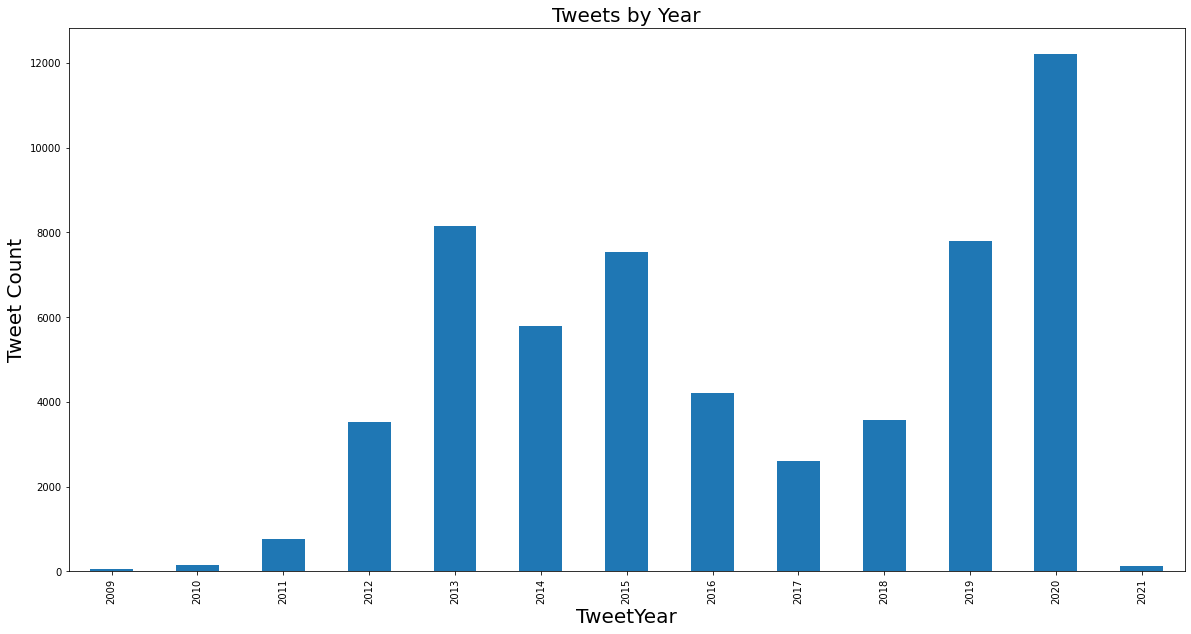

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xlabel("Tweet Year",fontsize=20)
plt.ylabel("Tweet Count",fontsize=20)
plt.title("Tweets by Year",fontsize=20)
trumpTweetsDf.groupby(['TweetYear'])['Tweet'].count().plot(kind="bar")
plt.show()

### Mr. Trump was very active in 2020

## Data Preprocessing

In [5]:
import re

#Removing links from tweets
trumpTweetsDf['Tweet'] = trumpTweetsDf['Tweet'].map(lambda x : re.sub('http(s)?\S+','',x))

#Removing special characters and mentions of people in his tweets
trumpTweetsDf['Tweet_Tokens'] = trumpTweetsDf['Tweet'].map(lambda x : re.sub('(@[a-zA-z]+)|([!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#]+)','',x))

#Removing extra lines
trumpTweetsDf['Tweet_Tokens'] = trumpTweetsDf['Tweet_Tokens'].map(lambda x: x.replace('\n',' '))

#Removing additional spaces and converting to lower case
trumpTweetsDf['Tweet_Tokens'] = trumpTweetsDf['Tweet_Tokens'].map(lambda x: re.sub("\\s+",' ',x.strip().lower()))


In [6]:
# Remove emojis from tweets

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [7]:
trumpTweetsDf['Tweet_Tokens'] = trumpTweetsDf['Tweet_Tokens'].map(lambda x: remove_emojis(x))
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1,rt wow we hear you from the west wing—thank you
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1,rt pennsylvania is going to trump the legislat...
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT!,False,False,2021,1,get smart republicans fight
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1,rt i wonder when the water main is gonna burst...
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1,rt democrats scrounging up votes from mystical...
...,...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5,my persona will never be that of a wallflower ...
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5,new blog post celebrity apprentice finale and ...
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5,donald trump reads top ten financial tips on l...
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5,donald trump will be appearing on the view tom...


In [8]:
#Create word tokens from tweets

from nltk.tokenize import word_tokenize
trumpTweetsDf['tokenized_words'] = trumpTweetsDf['Tweet_Tokens'].map(lambda x: word_tokenize(x))
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1,rt wow we hear you from the west wing—thank you,"[rt, wow, we, hear, you, from, the, west, wing..."
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1,rt pennsylvania is going to trump the legislat...,"[rt, pennsylvania, is, going, to, trump, the, ..."
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT!,False,False,2021,1,get smart republicans fight,"[get, smart, republicans, fight]"
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1,rt i wonder when the water main is gonna burst...,"[rt, i, wonder, when, the, water, main, is, go..."
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1,rt democrats scrounging up votes from mystical...,"[rt, democrats, scrounging, up, votes, from, m..."
...,...,...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5,my persona will never be that of a wallflower ...,"[my, persona, will, never, be, that, of, a, wa..."
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5,new blog post celebrity apprentice finale and ...,"[new, blog, post, celebrity, apprentice, final..."
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5,donald trump reads top ten financial tips on l...,"[donald, trump, reads, top, ten, financial, ti..."
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5,donald trump will be appearing on the view tom...,"[donald, trump, will, be, appearing, on, the, ..."


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')

necessary_removal=['link','amp','quot','rt']

stopwords.extend(necessary_removal)

#removing stopwords from the tweets as they don't contribute much to the overall sentiment

trumpTweetsDf['tokenized_words'] = trumpTweetsDf['tokenized_words'].map(lambda x: [item for item in x if item not in stopwords])

#Get root form of the word 
lemmatizer = WordNetLemmatizer()

trumpTweetsDf['tokenized_words'] = trumpTweetsDf['tokenized_words'].map(lambda x: [lemmatizer.lemmatize(item) for item in x])


trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1,rt wow we hear you from the west wing—thank you,"[wow, hear, west, wing—thank]"
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1,rt pennsylvania is going to trump the legislat...,"[pennsylvania, going, trump, legislator, spoken]"
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT!,False,False,2021,1,get smart republicans fight,"[get, smart, republican, fight]"
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1,rt i wonder when the water main is gonna burst...,"[wonder, water, main, gon, na, burst, georgia]"
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1,rt democrats scrounging up votes from mystical...,"[democrat, scrounging, vote, mystical, place]"
...,...,...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5,my persona will never be that of a wallflower ...,"[persona, never, wallflower, ’, rather, build,..."
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5,new blog post celebrity apprentice finale and ...,"[new, blog, post, celebrity, apprentice, final..."
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5,donald trump reads top ten financial tips on l...,"[donald, trump, read, top, ten, financial, tip..."
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5,donald trump will be appearing on the view tom...,"[donald, trump, appearing, view, tomorrow, mor..."


## Sentiment Analysis

We'll assign a sentiment and a sentiment score to each tweet and try to gain some insights from that 

In [10]:

#Create the sentiment function.We use Vader for this purpose & decide the sentiment from compound score.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vaderScore(review):
    sdr = SentimentIntensityAnalyzer()
    sentiment_dict = sdr.polarity_scores(' '.join(review))
    if(sentiment_dict['compound']>=0.5):
        return 'Positive',sentiment_dict['compound']
    elif(sentiment_dict['compound']<=-0.05):
        return 'Negative',sentiment_dict['compound']
    else:
        return 'Neutral',sentiment_dict['compound']
    return sentiment_dict
    

In [11]:
#Get sentiment and it's score in different columns

trumpTweetsDf['vader_score'] = trumpTweetsDf['tokenized_words'].apply(lambda x: vaderScore(x))
trumpTweetsDf['sentiment'],trumpTweetsDf['compound_score'] = zip(*trumpTweetsDf['vader_score'])
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1,rt wow we hear you from the west wing—thank you,"[wow, hear, west, wing—thank]","(Positive, 0.5859)",Positive,0.5859
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1,rt pennsylvania is going to trump the legislat...,"[pennsylvania, going, trump, legislator, spoken]","(Neutral, 0.0)",Neutral,0.0000
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT!,False,False,2021,1,get smart republicans fight,"[get, smart, republican, fight]","(Neutral, 0.0258)",Neutral,0.0258
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1,rt i wonder when the water main is gonna burst...,"[wonder, water, main, gon, na, burst, georgia]","(Neutral, 0.0)",Neutral,0.0000
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1,rt democrats scrounging up votes from mystical...,"[democrat, scrounging, vote, mystical, place]","(Neutral, 0.0)",Neutral,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5,my persona will never be that of a wallflower ...,"[persona, never, wallflower, ’, rather, build,...","(Neutral, 0.0)",Neutral,0.0000
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5,new blog post celebrity apprentice finale and ...,"[new, blog, post, celebrity, apprentice, final...","(Neutral, 0.0)",Neutral,0.0000
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5,donald trump reads top ten financial tips on l...,"[donald, trump, read, top, ten, financial, tip...","(Positive, 0.5719)",Positive,0.5719
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5,donald trump will be appearing on the view tom...,"[donald, trump, appearing, view, tomorrow, mor...","(Positive, 0.7506)",Positive,0.7506


## Looking at sentiments of Trump's tweets over the year

<AxesSubplot:title={'center':'Sentiments by Year'}, xlabel='Tweet Year', ylabel='Tweet Counts'>

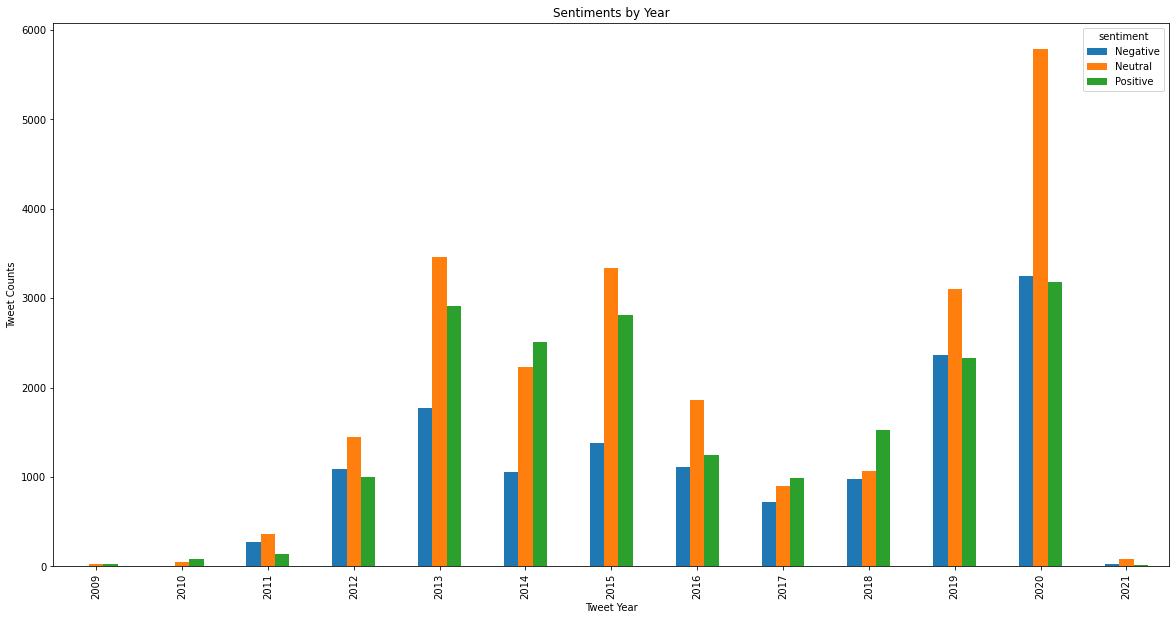

In [16]:
trumpTweetsDf.groupby(['sentiment','TweetYear'])['Tweet'].count().unstack('sentiment').plot(kind="bar",figsize=(20,10),title="Sentiments by Year",ylabel="Tweet Counts",xlabel="Tweet Year")

## Mr. Trump clearly spewed a lot of negative tweets than positive ones during his second run of presidency which could have contributed towards his loss

* The 2016 presidential campaign of Donald Trump was formally launched on June 16, 2015, at Trump Tower in New York City. The U.S. Congress certified the electoral result on January 6, 2017, and the new President and Vice President were inaugurated on January 20, 2017. 
* On June 18, 2019, Trump announced that he would seek re-election in the 2020 presidential election. The formal voting by the Electoral College took place on December 14. The U.S. Congress then certified the electoral result on January 7, 2021, and Joe Biden was inaugurated on January 20, 2021.
* If we notice the proportion of positive and negative tweets, we see that Mr. Trump had more positive tweets than negative tweets in the first election campaign in 2015 and 2016 and there were more negative tweets than positive tweets in the second campaign in 2019 and 2020. We all know the results of both campaigns.

## We'll now do some analysis on his deleted tweets and see why maybe his tweets were deleted

Let's first remove a few more stopwords which do not contribute much to the deleted word spectrum

In [21]:

extendedStopWords = ['u','get','make','also','know','year','yet','really','along','making','could','big','great','thank',
                   'via','come','take','one','came','like','see','time','today','need','always','number','since','told','nothing',''
                  ,'open','think','party','cool','temporary','use','day','check','look','medium'
                  ,'want','way','work','live','around','set','tweet','going','must','even','done','week','back','would',
                  'say','photo','let','last','first','wait','long','keep','getting','went','many','much','every','guy'
                      ,'really','else','back','center','bar','type','follow','dems','never','give','far','man'
                      'ever','including','totally','two','pm','mr','nk'
                  ,'thing','trying','pic','saw','thought','says','using','hrs','giving','got','made','said','dem','tomorrow','tonight','entire','anything','go']

stopwords.extend(extendedStopWords)

trumpTweetsDf['tokenized_words'] = trumpTweetsDf['tokenized_words'].map(lambda x: [item for item in x if item not in stopwords])

trumpTweetsDf['Final Sentence'] = trumpTweetsDf['tokenized_words'].apply(lambda y: ' '.join(y))
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score,Final Sentence
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1,rt wow we hear you from the west wing—thank you,"[wow, hear, west, wing—thank]","(Positive, 0.5859)",Positive,0.5859,wow hear west wing—thank
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1,rt pennsylvania is going to trump the legislat...,"[pennsylvania, trump, legislator, spoken]","(Neutral, 0.0)",Neutral,0.0000,pennsylvania trump legislator spoken
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT!,False,False,2021,1,get smart republicans fight,"[smart, republican, fight]","(Neutral, 0.0258)",Neutral,0.0258,smart republican fight
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1,rt i wonder when the water main is gonna burst...,"[wonder, water, main, gon, na, burst, georgia]","(Neutral, 0.0)",Neutral,0.0000,wonder water main gon na burst georgia
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1,rt democrats scrounging up votes from mystical...,"[democrat, scrounging, vote, mystical, place]","(Neutral, 0.0)",Neutral,0.0000,democrat scrounging vote mystical place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5,my persona will never be that of a wallflower ...,"[persona, wallflower, ’, rather, build, wall, ...","(Neutral, 0.0)",Neutral,0.0000,persona wallflower ’ rather build wall cling d...
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5,new blog post celebrity apprentice finale and ...,"[new, blog, post, celebrity, apprentice, final...","(Neutral, 0.0)",Neutral,0.0000,new blog post celebrity apprentice finale less...
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5,donald trump reads top ten financial tips on l...,"[donald, trump, read, top, ten, financial, tip...","(Positive, 0.5719)",Positive,0.5719,donald trump read top ten financial tip late s...
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5,donald trump will be appearing on the view tom...,"[donald, trump, appearing, view, morning, disc...","(Positive, 0.7506)",Positive,0.7506,donald trump appearing view morning discus cel...


,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score,Final Sentence
128,2021-01-01 14:23:09,19000,66000,"The BIG Protest Rally in Washington, D.C., wil...",True,False,2021,1,the big protest rally in washington dc will ta...,"[protest, rally, washington, dc, place, 1100, ...","(Negative, -0.25)",Negative,-0.2500,protest rally washington dc place 1100 january...
136,2020-12-31 23:02:11,14000,0,"RT @TheFirstonTV: Joe Biden did a ""victory lap...",True,True,2020,12,rt joe biden did a victory lap but had a lot o...,"[joe, biden, victory, lap, lot, trouble, speak...","(Negative, -0.6344)",Negative,-0.6344,joe biden victory lap lot trouble speaking maj...
209,2020-12-26 08:25:56,15000,73000,"I simply want to get out great people $2000, r...",True,False,2020,12,i simply want to get out great people 2000 rat...,"[simply, people, 2000, rather, measly, 600, bi...","(Neutral, 0.4939)",Neutral,0.4939,simply people 2000 rather measly 600 bill stop...
212,2020-12-26 07:58:50,5000,19000,"I simply wan to get our great people $2000, ra...",True,False,2020,12,i simply wan to get our great people 2000 rath...,"[simply, wan, people, 2000, rather, 600, congr...","(Neutral, 0.4588)",Neutral,0.4588,simply wan people 2000 rather 600 congress cut...
214,2020-12-26 07:51:34,4000,0,"RT @ali: Our friend, Congressman @andybiggs4az...",True,True,2020,12,rt our friend congressman 4az has this video m...,"[friend, congressman, 4az, video, message, ari...","(Neutral, 0.4939)",Neutral,0.4939,friend congressman 4az video message arizona s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29804,2016-02-18 02:42:00,4000,0,RT @TomOdell: .@FoxNews - Pope who lives in a ...,True,True,2016,2,rt foxnews pope who lives in a vatican city fo...,"[foxnews, pope, life, vatican, city, fortified...","(Negative, -0.2023)",Negative,-0.2023,foxnews pope life vatican city fortified huge ...
30010,2016-02-05 06:13:50,3000,0,RT @seanhannity: Watch: Donald Trump OWNS A He...,True,True,2016,2,rt watch donald trump owns a heckler who said ...,"[watch, donald, trump, owns, heckler, illegal,...","(Negative, -0.5574)",Negative,-0.5574,watch donald trump owns heckler illegal immigr...
30052,2016-02-02 02:33:38,2000,0,RT @namusca: #VoteTrump2016 a real leader that...,True,True,2016,2,rt votetrump2016 a real leader that truly care...,"[votetrump2016, real, leader, truly, care, ame...","(Positive, 0.8316)",Positive,0.8316,votetrump2016 real leader truly care america v...
30148,2016-01-27 04:05:45,2000,0,"RT @DRUDGE_REPORT: LIMBAUGH: By not showing, h...",True,True,2016,1,rt limbaugh by not showing hes owning entire e...,"[limbaugh, showing, owning, event]","(Neutral, 0.0)",Neutral,0.0000,limbaugh showing owning event


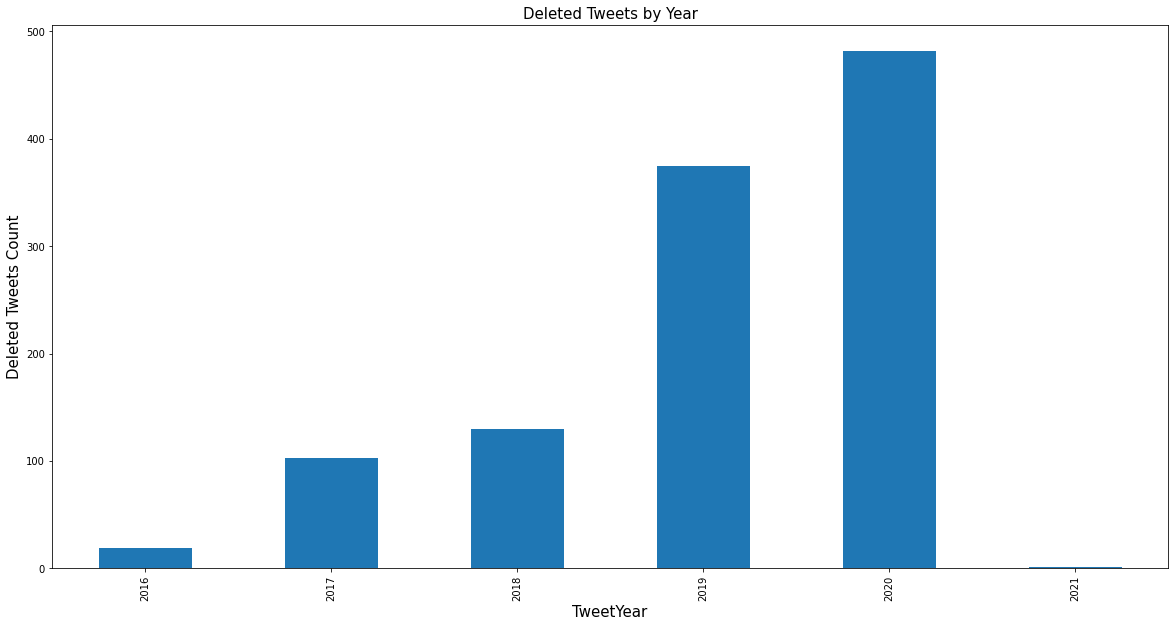

In [24]:
plt.xlabel("Tweet Year",fontsize=15)
plt.ylabel("Deleted Tweets Count",fontsize=15)
plt.title("Deleted Tweets by Year",fontsize=15)

trumpDeletedTweets = trumpTweetsDf[trumpTweetsDf['WasDeleted']==True]
trumpDeletedTweets.groupby(['TweetYear'])['Tweet'].count().plot(kind="bar",figsize=(20,10))
trumpDeletedTweets

## His tweets were more and more deleted as the years went by. It may be down to the fact that negative sentiment tweets were getting bigger and bigger

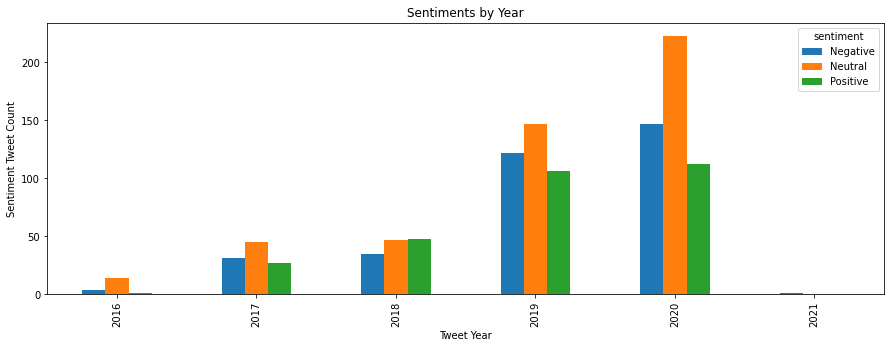

In [34]:
trumpDeletedTweets.groupby(['sentiment','TweetYear'])['Tweet'].count().unstack('sentiment').plot(kind="bar",figsize=(15,5),xlabel="Tweet Year",ylabel="Sentiment Tweet Count",title="Sentiments by Year")
plt.show()

**It will be fun to compare the 2015-16 and 2019-20 Election Campaign and understand ome of the reasons why he may have won the first but lost the second election**

**We know from above that he had more positive sentiment tweets than negative ones in 2015-16 election campaign. But what was the effect of both positive and negative tweets on the people in both campaigns? We can look into this from the likes and retweets section**

<Figure size 1440x720 with 0 Axes>

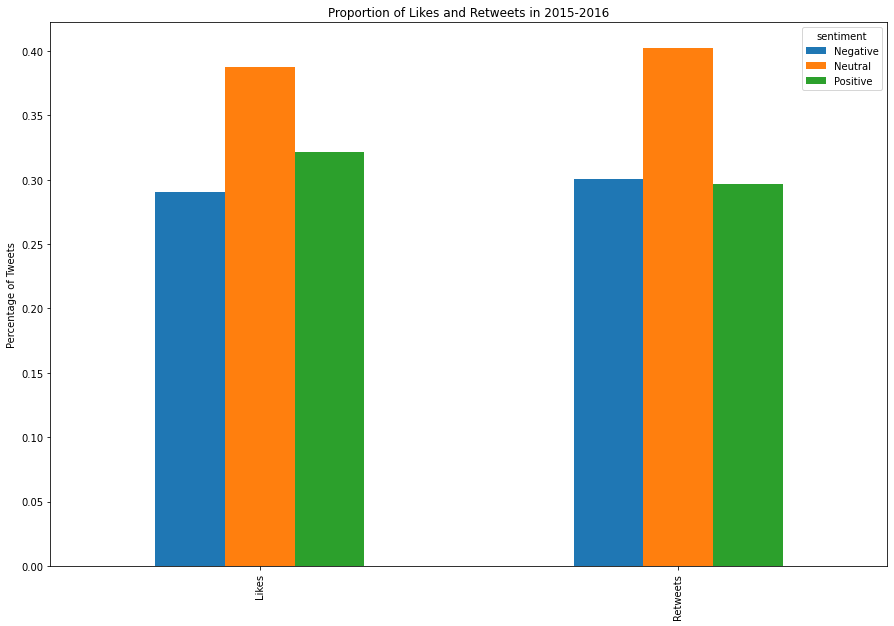

In [36]:
plt.figure(figsize=(20,10))

firstCampaign = trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2015,2016])]
firstCampaign_LikesPercentage = (firstCampaign.groupby(['sentiment'])['Likes'].sum())/firstCampaign['Likes'].sum()
firstCampaign_RetweetsPercentage = (firstCampaign.groupby(['sentiment'])['Retweets'].sum())/firstCampaign['Retweets'].sum()
#firstCampaign.groupby(['sentiment'])['Likes','Retweets'].sum().plot(kind="bar")
firstCampaign_LikesPercentage.to_frame().join(firstCampaign_RetweetsPercentage).T.plot(kind="bar",figsize=(15,10),ylabel='Percentage of Tweets',title='Proportion of Likes and Retweets in 2015-2016')
plt.show()

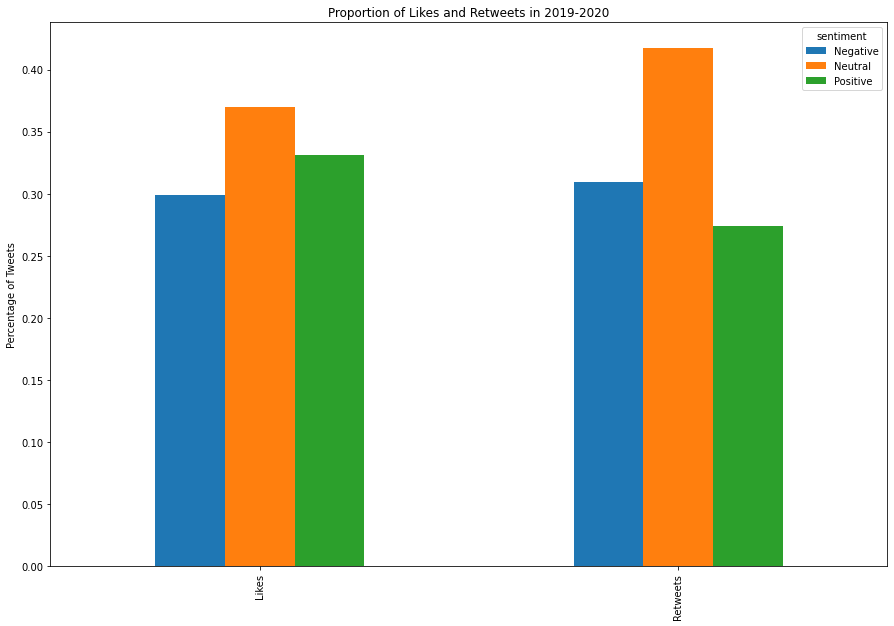

In [35]:
secondCampaign = trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2019,2020])]
secondCampaign_LikesPercentage = (secondCampaign.groupby(['sentiment'])['Likes'].sum())/secondCampaign['Likes'].sum()
secondCampaign_RetweetsPercentage = (secondCampaign.groupby(['sentiment'])['Retweets'].sum())/secondCampaign['Retweets'].sum()
#firstCampaign.groupby(['sentiment'])['Likes','Retweets'].sum().plot(kind="bar")
secondCampaign_LikesPercentage.to_frame().join(secondCampaign_RetweetsPercentage).T.plot(kind="bar",figsize=(15,10),ylabel='Percentage of Tweets',title='Proportion of Likes and Retweets in 2019-2020')
plt.show()

The proportion of positive tweet retweets reduced  in the second election campaign. Even though we see that the negative sentiments didn't really take a hit from the first campaign and proportion of likes also remained pretty much same, the lesser number of retweets can be look at from a sense of lesser proportion of people supporting Trump's policies

## WordCloud for 2015-2016 Election Campaign

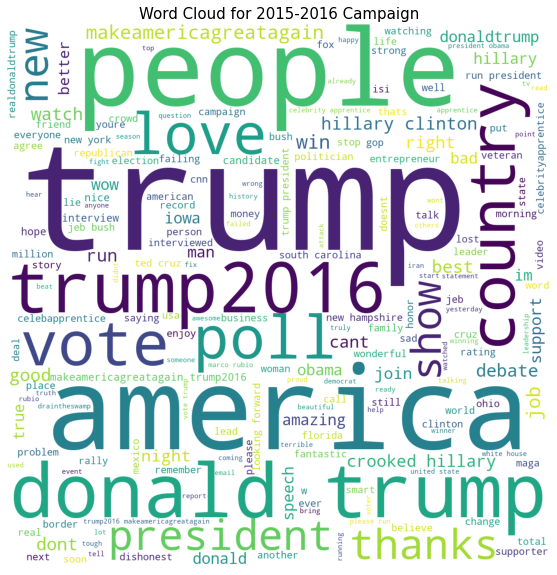

In [38]:
from wordcloud import WordCloud


plt.figure(figsize=(20,10))
wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = stopwords,
                random_state=1,
                min_font_size = 10).generate(' '.join(trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2015,2016])]['Final Sentence']))

plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud for 2015-2016 Campaign',fontdict = {'fontsize' : 15})
plt.show()

## WordCloud for 2019-2020 Election Campaign

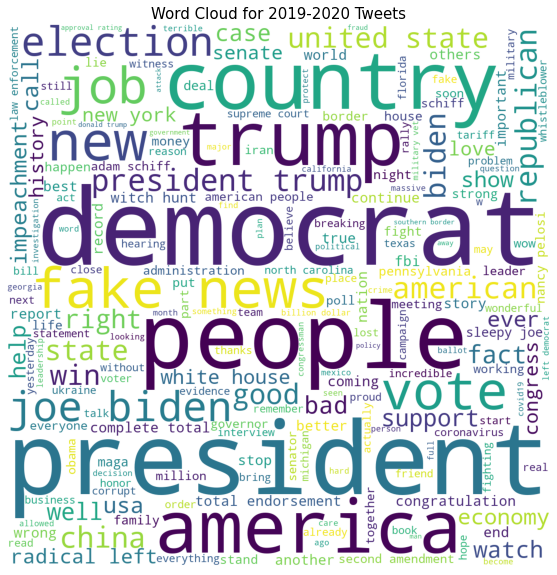

In [39]:
plt.figure(figsize=(20,10))
wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = stopwords,
                random_state=1,
                 min_font_size = 10).generate(' '.join(trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2019,2020])]['Final Sentence']))

plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud for 2019-2020 Tweets',fontdict = {'fontsize' : 15})
plt.show()

Now we see some interesting things here.

* Trump really likes to talk lot about himself. Like a lot!!
* In 2015, we see love, makeamericagreatagain (maga),entrepreneur,business,isi at the forefront along with the negative words like Crooked Hillary but the general sentimment seemed positive only
* Compare that to 2019 and straightaway it seems there is a lot more negativity associated with fake news, impeachment, witch hunt being at the forefront of his tweets.
* Notice that in 2019-2020 wordcloud, where coronavirus was by far the most prevalent topic in the whole world, Mr. Trump found a way to decrease it's magnitude while blaming china for the whole thing as can be seen from how China is so frequent in his tweets
* Jobs were not much talked about in his tweets in 2015 as compared to 2019.

In [88]:
##Seeing top 10 topics in his first run

from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
vectorizer = TfidfVectorizer(norm = None)
tfidf_scores = vectorizer.fit_transform(firstRun)
feature_names = vectorizer.get_feature_names()
tfidf_scores = vectorizer.fit_transform(firstRun)
nmf = NMF(n_components=10, random_state=1,max_iter=400).fit(tfidf_scores)


for topic_idx, topic in enumerate(nmf.components_):
    topic_elements = [feature_names[i]for i in topic.argsort()[:-10 - 1:-1]]
    print("Topic #{0}: {1}".format(topic_idx,topic_elements))

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: ['trump', 'the', 'times', 'pres', 'news', 'vote', 'run', 'country', 'and', 'great']
Topic #1: ['america', 'she', 'beat', 'job', 'smart', 'dont', 'thanks', 'advantage', 'cant', 'watch']
Topic #2: ['trump2016', 'job', 'smart', 'thanks', 'advantage', 'cant', 'watch', 'best', 'crooked', 'american']
Topic #3: ['donald', 'country', 'iowa', 'say', 'exclusive', 'great', 'to', 'incompetent', 'pieces', 'pathway']
Topic #4: ['president', 'vote', 'love', 'clinton', 'show', 'good', 'then', 'win', 'dont', 'nielsen']
Topic #5: ['hillary', 'wow', 'brothers', 'nevada', 'run', 'and', 'job', 'show', 'tapped', 'choice']
Topic #6: ['people', 'vote', 'clinton', 'love', 'show', 'then', 'win', 'good', 'dont', 'best']
Topic #7: ['makeamericagreatagain', 'vote', 'country', 'run', 'great', 'to', 'incompetent', 'and', 'clinton', 'love']
Topic #8: ['new', 'run', 'and', 'tapped', 'choice', 'idea', 'talent', 'job', 'smart', 'debate']
Topic #9: ['poll', 'vote', 'love', 'thanks', 'dont', 'cant', 'crooked', '

In [89]:
##Seeing top 10 topics in his second run

from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
vectorizer = TfidfVectorizer(norm = None)
tfidf_scores = vectorizer.fit_transform(secondRun)
feature_names = vectorizer.get_feature_names()
tfidf_scores = vectorizer.fit_transform(secondRun)
nmf = NMF(n_components=10, random_state=1,max_iter=400).fit(tfidf_scores)


for topic_idx, topic in enumerate(nmf.components_):
    topic_elements = [feature_names[i]for i in topic.argsort()[:-10 - 1:-1]]
    print("Topic #{0}: {1}".format(topic_idx,topic_elements))

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: ['president', 'tonight', 'deregulation', 'amendment', 'also', 'vote', 'job', 'fake', 'america', 'joe']
Topic #1: ['democrat', 'vote', 'america', 'republican', 'election', 'joe', '3rd', 'now', 'not', 'and']
Topic #2: ['trump', 'russia', 'not', 'america', 'against', 'cooperation', 'planet', 'conduct', 'heritage', 'now']
Topic #3: ['people', 'including', 'world', 'on', 'won', 'are', 'and', 'job', 'fake', 'florida']
Topic #4: ['state', 'locking', 'this', 'tasked', 'report', 'one', 'republican', 'joe', 'america', 'election']
Topic #5: ['american', 'job', 'fake', 'nk', 'impeachment', 'house', 'good', 'for', 'united', 'trophy']
Topic #6: ['country', 'and', 'through', 'substance', 'whether', 'america', 'florida', 'process', 'economy', 'deal']
Topic #7: ['news', 'america', 'joe', 'republican', 'election', 'now', 'not', 'and', 'deserve', 'impeachment']
Topic #8: ['biden', '44', 'fake', 'nk', 'impeachment', 'border', 'house', 'good', 'for', 'united']
Topic #9: ['new', 'job', 'fake', 'nk

In [40]:
### Lift analysis between some election terms and first and second election run

trumpTweetsDf.to_csv('TwitterTrumpSentimentScores.csv',index=False)


In [104]:
firstElection = trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2015,2016])]
firstElection['sentiment']

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score,Final Sentence
26324,2016-12-31 13:59:04,8000,0,RT @realDonaldTrump: Happy Birthday @DonaldJTr...,False,True,2016,12,rt happy birthday,"[happy, birthday]","(Positive, 0.5719)",Positive,0.5719,happy birthday
26325,2016-12-31 13:58:12,8000,47000,Happy Birthday @DonaldJTrumpJr!,False,False,2016,12,happy birthday,"[happy, birthday]","(Positive, 0.5719)",Positive,0.5719,happy birthday
26326,2016-12-31 08:17:21,114000,300000,"Happy New Year to all, including to my many en...",False,False,2016,12,happy new year to all including to my many ene...,"[happy, new, enemy, fought, lost, badly, dont,...","(Negative, -0.871)",Negative,-0.8710,happy new enemy fought lost badly dont love
26327,2016-12-30 17:18:18,18000,69000,Russians are playing @CNN and @NBCNews for suc...,False,False,2016,12,russians are playing and for such fools funny ...,"[russian, playing, fool, funny, watch, dont, c...","(Neutral, 0.2023)",Neutral,0.2023,russian playing fool funny watch dont clue
26328,2016-12-30 14:46:55,6000,21000,"Join @AmerIcan32, founded by Hall of Fame lege...",False,False,2016,12,join 32 founded by hall of fame legend 32 on 1...,"[join, 32, founded, hall, fame, legend, 32, 11...","(Positive, 0.6249)",Positive,0.6249,join 32 founded hall fame legend 32 1192017 wa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38072,2015-01-01 02:05:27,16,39,"""@yankeejayman: @realDonaldTrump @flicka__ Do ...",False,False,2015,1,yankeejayman do u ever sleep not much,"[yankeejayman, ever, sleep]","(Neutral, 0.0)",Neutral,0.0000,yankeejayman ever sleep
38073,2015-01-01 02:04:45,22,51,"""@TalentlessCook: @realDonaldTrump You're only...",False,False,2015,1,talentlesscook youre only a year away from 201...,"[talentlesscook, youre, away, 2016, pick, runn...","(Positive, 0.5719)",Positive,0.5719,talentlesscook youre away 2016 pick running ma...
38074,2015-01-01 02:04:33,28,52,"""@archangeljf12: ;,@realDonaldTrump for Presid...",False,False,2015,1,archangeljf12 realdonaldtrump for president of...,"[archangeljf12, realdonaldtrump, president, un...","(Neutral, 0.4215)",Neutral,0.4215,archangeljf12 realdonaldtrump president united...
38075,2015-01-01 02:02:39,42,91,The Mar-a-Lago Club was amazing tonight. Every...,False,False,2015,1,the maralago club was amazing tonight everybod...,"[maralago, club, amazing, everybody, biggest, ...","(Positive, 0.8957)",Positive,0.8957,maralago club amazing everybody biggest hottes...


In [41]:
trumpTweetsDf['tokenized_tweets_unique'] = trumpTweetsDf['tokenized_words'].apply(lambda s: sorted(set(s)))
trumpTweetsDf

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score,Final Sentence,tokenized_tweets_unique
0,2021-01-06 00:47:01,48000,0,RT @DanScavino: 🔊WOW! We hear you from the Wes...,False,True,2021,1,rt wow we hear you from the west wing—thank you,"[wow, hear, west, wing—thank]","(Positive, 0.5859)",Positive,0.5859,wow hear west wing—thank,"[hear, west, wing—thank, wow]"
1,2021-01-06 00:46:29,31000,0,RT @christina_bobb: Pennsylvania is going to T...,False,True,2021,1,rt pennsylvania is going to trump the legislat...,"[pennsylvania, trump, legislator, spoken]","(Neutral, 0.0)",Neutral,0.0000,pennsylvania trump legislator spoken,"[legislator, pennsylvania, spoken, trump]"
2,2021-01-06 00:43:42,26000,127000,Get smart Republicans. FIGHT!,False,False,2021,1,get smart republicans fight,"[smart, republican, fight]","(Neutral, 0.0258)",Neutral,0.0258,smart republican fight,"[fight, republican, smart]"
3,2021-01-06 00:17:52,11000,0,RT @TomiLahren: I wonder when the water main i...,False,True,2021,1,rt i wonder when the water main is gonna burst...,"[wonder, water, main, gon, na, burst, georgia]","(Neutral, 0.0)",Neutral,0.0000,wonder water main gon na burst georgia,"[burst, georgia, gon, main, na, water, wonder]"
4,2021-01-06 00:17:43,14000,0,RT @TomiLahren: Democrats scrounging up votes ...,False,True,2021,1,rt democrats scrounging up votes from mystical...,"[democrat, scrounging, vote, mystical, place]","(Neutral, 0.0)",Neutral,0.0000,democrat scrounging vote mystical place,"[democrat, mystical, place, scrounging, vote]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56510,2009-05-12 10:07:28,1000,2000,"""My persona will never be that of a wallflower...",False,False,2009,5,my persona will never be that of a wallflower ...,"[persona, wallflower, ’, rather, build, wall, ...","(Neutral, 0.0)",Neutral,0.0000,persona wallflower ’ rather build wall cling d...,"[build, cling, donald, j, persona, rather, tru..."
56511,2009-05-08 16:40:15,11,29,New Blog Post: Celebrity Apprentice Finale and...,False,False,2009,5,new blog post celebrity apprentice finale and ...,"[new, blog, post, celebrity, apprentice, final...","(Neutral, 0.0)",Neutral,0.0000,new blog post celebrity apprentice finale less...,"[apprentice, blog, celebrity, finale, learned,..."
56512,2009-05-08 09:38:08,15,37,Donald Trump reads Top Ten Financial Tips on L...,False,False,2009,5,donald trump reads top ten financial tips on l...,"[donald, trump, read, top, ten, financial, tip...","(Positive, 0.5719)",Positive,0.5719,donald trump read top ten financial tip late s...,"[david, donald, financial, funny, late, letter..."
56513,2009-05-04 21:00:10,34,259,Donald Trump will be appearing on The View tom...,False,False,2009,5,donald trump will be appearing on the view tom...,"[donald, trump, appearing, view, morning, disc...","(Positive, 0.7506)",Positive,0.7506,donald trump appearing view morning discus cel...,"[appearing, apprentice, book, celebrity, champ..."


In [45]:
#Lift Analysis of Presidential Run (2015-2016)

trumpTweetsDf_run1 = trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2015,2016])]

#Frequency of words
freq_words1 = trumpTweetsDf_run1['tokenized_tweets_unique'].sum()
freq_dist1 = nltk.FreqDist(freq_words1)

#Word list for Lift Analysis

word_list=['hiliary','people','makeamericagreatagain','american','amendment','economy','corrupt','hoax','russia','pennsylvania','radical','democrats','biden','fake','china','media','impeachment','job','republican','schiff','border','coronavirus','covid','pelosi','obama']
freq_dist1.most_common(100)

[('trump', 2049),
 ('america', 774),
 ('trump2016', 774),
 ('donald', 732),
 ('president', 708),
 ('hillary', 612),
 ('people', 587),
 ('makeamericagreatagain', 560),
 ('new', 515),
 ('poll', 468),
 ('vote', 446),
 ('’', 445),
 ('country', 435),
 ('run', 421),
 ('love', 376),
 ('clinton', 373),
 ('job', 336),
 ('show', 332),
 ('“', 331),
 ('”', 316),
 ('thanks', 305),
 ('good', 299),
 ('debate', 299),
 ('win', 298),
 ('dont', 291),
 ('best', 266),
 ('watch', 264),
 ('cant', 263),
 ('night', 238),
 ('crooked', 233),
 ('american', 232),
 ('cruz', 228),
 ('state', 215),
 ('im', 214),
 ('obama', 213),
 ('amazing', 213),
 ('right', 212),
 ('join', 205),
 ('bad', 202),
 ('iowa', 201),
 ('support', 200),
 ('candidate', 199),
 ('nice', 198),
 ('crowd', 194),
 ('2016', 189),
 ('true', 188),
 ('speech', 188),
 ('campaign', 185),
 ('deal', 174),
 ('please', 173),
 ('hope', 172),
 ('wow', 172),
 ('ever', 171),
 ('republican', 169),
 ('enjoy', 166),
 ('man', 166),
 ('jeb', 165),
 ('donaldtrump', 16

In [47]:
tweetWord1=pd.Series(freq_dist1)
trumpTweetsDf_run1_freq=pd.DataFrame(tweetWord1)
trumpTweetsDf_run1_freq.reset_index(drop=False,inplace=True)

trumpTweetsDf_run1_freq.columns=['Word','Freq']
matched_words=trumpTweetsDf_run1_freq[trumpTweetsDf_run1_freq['Word'].isin(word_list)].sort_values(by='Freq',ascending=False)
matched_words

,Word,Freq
121,people,587
339,makeamericagreatagain,560
130,job,336
347,american,232
85,obama,213
1946,republican,169
678,border,130
365,pennsylvania,57
1621,economy,47
311,china,46


In [54]:
trumpTweetsDf_run1

,Date,Retweets,Likes,Tweet,WasDeleted,isRetweet,TweetYear,TweetMonth,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score,Final Sentence,tokenized_tweets_unique
26324,2016-12-31 13:59:04,8000,0,RT @realDonaldTrump: Happy Birthday @DonaldJTr...,False,True,2016,12,rt happy birthday,"[happy, birthday]","(Positive, 0.5719)",Positive,0.5719,happy birthday,"[birthday, happy]"
26325,2016-12-31 13:58:12,8000,47000,Happy Birthday @DonaldJTrumpJr!,False,False,2016,12,happy birthday,"[happy, birthday]","(Positive, 0.5719)",Positive,0.5719,happy birthday,"[birthday, happy]"
26326,2016-12-31 08:17:21,114000,300000,"Happy New Year to all, including to my many en...",False,False,2016,12,happy new year to all including to my many ene...,"[happy, new, enemy, fought, lost, badly, dont,...","(Negative, -0.871)",Negative,-0.8710,happy new enemy fought lost badly dont love,"[badly, dont, enemy, fought, happy, lost, love..."
26327,2016-12-30 17:18:18,18000,69000,Russians are playing @CNN and @NBCNews for suc...,False,False,2016,12,russians are playing and for such fools funny ...,"[russian, playing, fool, funny, watch, dont, c...","(Neutral, 0.2023)",Neutral,0.2023,russian playing fool funny watch dont clue,"[clue, dont, fool, funny, playing, russian, wa..."
26328,2016-12-30 14:46:55,6000,21000,"Join @AmerIcan32, founded by Hall of Fame lege...",False,False,2016,12,join 32 founded by hall of fame legend 32 on 1...,"[join, 32, founded, hall, fame, legend, 32, 11...","(Positive, 0.6249)",Positive,0.6249,join 32 founded hall fame legend 32 1192017 wa...,"[1192017, 32, dc, fame, founded, hall, join, l..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38072,2015-01-01 02:05:27,16,39,"""@yankeejayman: @realDonaldTrump @flicka__ Do ...",False,False,2015,1,yankeejayman do u ever sleep not much,"[yankeejayman, ever, sleep]","(Neutral, 0.0)",Neutral,0.0000,yankeejayman ever sleep,"[ever, sleep, yankeejayman]"
38073,2015-01-01 02:04:45,22,51,"""@TalentlessCook: @realDonaldTrump You're only...",False,False,2015,1,talentlesscook youre only a year away from 201...,"[talentlesscook, youre, away, 2016, pick, runn...","(Positive, 0.5719)",Positive,0.5719,talentlesscook youre away 2016 pick running ma...,"[2016, away, happy, mate, new, pick, running, ..."
38074,2015-01-01 02:04:33,28,52,"""@archangeljf12: ;,@realDonaldTrump for Presid...",False,False,2015,1,archangeljf12 realdonaldtrump for president of...,"[archangeljf12, realdonaldtrump, president, un...","(Neutral, 0.4215)",Neutral,0.4215,archangeljf12 realdonaldtrump president united...,"[archangeljf12, president, realdonaldtrump, st..."
38075,2015-01-01 02:02:39,42,91,The Mar-a-Lago Club was amazing tonight. Every...,False,False,2015,1,the maralago club was amazing tonight everybod...,"[maralago, club, amazing, everybody, biggest, ...","(Positive, 0.8957)",Positive,0.8957,maralago club amazing everybody biggest hottes...,"[amazing, beach, best, biggest, club, everybod..."


In [55]:
# counting the occurence 
words = matched_words['Word'].values
l=[]
matrix=pd.DataFrame(columns=range(len(words)),index=range(len(words)))
dis_matrix = pd.DataFrame(columns=range(len(words)),index=range(len(words)))

n=len(trumpTweetsDf_run1)
for i in range(len(words)):
    for j in range(i+1,len(words)):
        counti=0
        countj=0
        countij=0
        for k in trumpTweetsDf_run1['tokenized_tweets_unique']:
            if words[i] in k and words[j] in k:
                countij+=1
            if words[i] in k:
                counti+=1
            if words[j] in k:
                countj+=1
            else:
                pass
        l.append([words[i],words[j],counti,countj,countij])
        matrix.loc[i,j]=(countij*n)/(counti*countj)
        matrix.loc[j,i]=(countij*n)/(counti*countj)
        try:
            dis_matrix.loc[i,j]=(counti*countj)/(countij*n)
        except ZeroDivisionError:
            dis_matrix.loc[i,j] = 0.0
        try:
            dis_matrix.loc[j,i]=(counti*countj)/(countij*n)
        except ZeroDivisionError:
            dis_matrix.loc[j,i] = 0.0
matrix    

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,0.536307,1.310974,3.883606,1.128008,1.777114,1.386149,0.0,2.130016,0.435264,0.645876,1.33481,0.0,1.33481,0.0,0.0,0.0
1,0.536307,NaN,0.43724,0.995097,0.098533,0.248373,0.161442,4.050219,1.78617,0.0,0.0,1.399167,0.0,0.0,0.0,0.0,0.0
2,1.310974,0.43724,NaN,1.658495,1.14955,1.034887,1.883494,3.068348,6.698138,3.802083,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.883606,0.995097,1.658495,NaN,2.616217,0.899281,1.948442,0.0,6.467168,3.303879,0.0,0.0,0.0,3.377299,0.0,0.0,0.0
4,1.128008,0.098533,1.14955,2.616217,NaN,2.938495,0.848899,0.0,2.348017,1.199531,12.45964,0.0,5.808253,0.0,0.0,11.035681,0.0
5,1.777114,0.248373,1.034887,0.899281,2.938495,NaN,1.069914,0.0,2.959335,0.0,0.0,2.318146,0.0,0.0,0.0,0.0,0.0
6,1.386149,0.161442,1.883494,1.948442,0.848899,1.069914,NaN,0.0,1.923568,1.965385,2.916377,3.01359,0.0,0.0,0.0,0.0,0.0
7,0.0,4.050219,3.068348,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.130016,1.78617,6.698138,6.467168,2.348017,2.959335,1.923568,0.0,NaN,0.0,0.0,0.0,0.0,16.670922,0.0,0.0,0.0
9,0.435264,0.0,3.802083,3.303879,1.199531,0.0,1.965385,0.0,0.0,NaN,0.0,0.0,80.684211,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Lift score heat map'}>

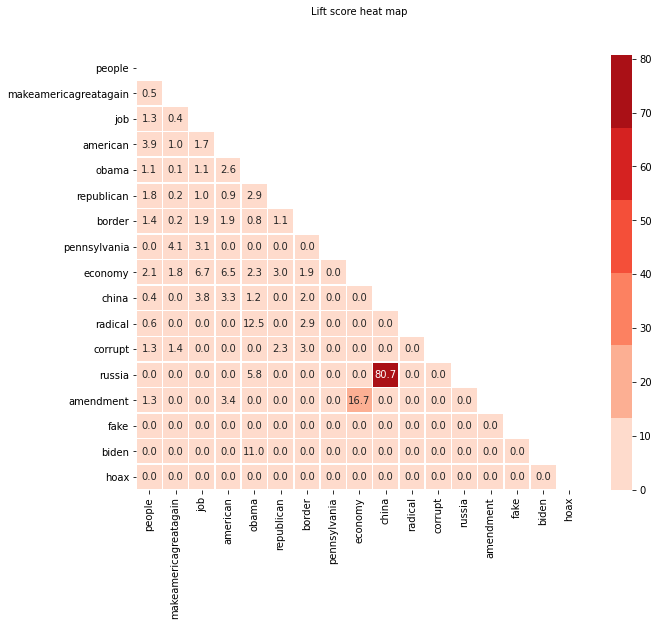

In [56]:
import numpy as np
import seaborn as sns
#Lift Analysis of Presidential Run (2015-2016)
matrix.index=words
matrix.columns=words
matrix.fillna(0, inplace=True)

mask = np.triu(np.ones_like(matrix))
colormap= sns.color_palette("Reds")

plt.figure(figsize=(10,8))
plt.title('Lift score heat map', fontsize = 10, pad = 40)
sns.heatmap(matrix, linewidths=0.5, annot=True, fmt=".1f", annot_kws={"fontsize":10},cmap=colormap,mask=mask)

In [57]:
dis_matrix.index=words
dis_matrix.columns=words
dis_matrix

,people,makeamericagreatagain,job,american,obama,republican,border,pennsylvania,economy,china,radical,corrupt,russia,amendment,fake,biden,hoax
people,NaN,1.864602,0.762792,0.257493,0.886518,0.56271,0.721423,0.0,0.46948,2.297456,1.548286,0.74917,0.0,0.74917,0.0,0.0,0.0
makeamericagreatagain,1.864602,NaN,2.287076,1.004927,10.148898,4.026206,6.194163,0.2469,0.559857,0.0,0.0,0.714711,0.0,0.0,0.0,0.0,0.0
job,0.762792,2.287076,NaN,0.602956,0.869906,0.966289,0.530928,0.325908,0.149295,0.263014,0.0,0.0,0.0,0.0,0.0,0.0,0.0
american,0.257493,1.004927,0.602956,NaN,0.382231,1.112,0.513231,0.0,0.154627,0.302674,0.0,0.0,0.0,0.296095,0.0,0.0,0.0
obama,0.886518,10.148898,0.869906,0.382231,NaN,0.34031,1.177997,0.0,0.425891,0.833659,0.080259,0.0,0.172169,0.0,0.0,0.090615,0.0
republican,0.56271,4.026206,0.966289,1.112,0.34031,NaN,0.934655,0.0,0.337914,0.0,0.0,0.431379,0.0,0.0,0.0,0.0,0.0
border,0.721423,6.194163,0.530928,0.513231,1.177997,0.934655,NaN,0.0,0.519867,0.508806,0.342891,0.33183,0.0,0.0,0.0,0.0,0.0
pennsylvania,0.0,0.2469,0.325908,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
economy,0.46948,0.559857,0.149295,0.154627,0.425891,0.337914,0.519867,0.0,NaN,0.0,0.0,0.0,0.0,0.059985,0.0,0.0,0.0
china,2.297456,0.0,0.263014,0.302674,0.833659,0.0,0.508806,0.0,0.0,NaN,0.0,0.0,0.012394,0.0,0.0,0.0,0.0


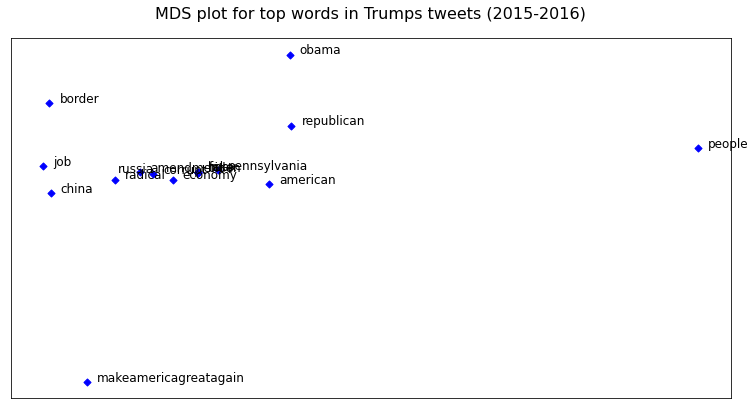

In [60]:
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn import manifold

#MDS Plot
dis_matrix=dis_matrix.fillna(0)
mdsmatrix= dis_matrix.values

mds=manifold.MDS(n_components=2, dissimilarity ='precomputed', random_state=1)

results=mds.fit(mdsmatrix)
coords=results.embedding_

x=coords[:,0]
y=coords[:,1]

plt.figure(figsize=(10,5)) 


ax=plt.axes([0.,0.,1.,1.])
plt.title('MDS plot for top words in Trumps tweets (2015-2016)', fontsize = 16, pad = 20)
plt.scatter(x, y, marker='D', color='blue', s = 25)

n=list(dis_matrix.index)

for i in range(len(n)):
    if n[i] == 'russia':
        ax.annotate(n[i], xy= (x[i] - 0.08, y[i] + 0.01), fontsize = 12)
    else:
        ax.annotate(n[i], xy = (x[i] + 0.01, y[i] + 0.01), fontsize = 12)


plt.xticks([])
plt.yticks([])
plt.show()

In [61]:
#Lift Analysis of Presidential Run (2019-2020)
trumpTweetsDf_run2 = trumpTweetsDf[trumpTweetsDf['TweetYear'].isin([2019,2020])]

#Frequency of words
freq_words2 = trumpTweetsDf_run2['tokenized_tweets_unique'].sum()
freq_dist2 = nltk.FreqDist(freq_words2)
freq_dist2.most_common(100)

[('’', 3949),
 ('“', 2372),
 ('president', 2254),
 ('”', 2089),
 ('democrat', 1705),
 ('trump', 1638),
 ('people', 1409),
 ('state', 1151),
 ('country', 1035),
 ('american', 1028),
 ('news', 1022),
 ('new', 945),
 ('biden', 925),
 ('job', 836),
 ('fake', 789),
 ('vote', 758),
 ('america', 756),
 ('republican', 755),
 ('joe', 708),
 ('election', 687),
 ('impeachment', 624),
 ('house', 596),
 ('good', 542),
 ('border', 523),
 ('win', 500),
 ('united', 488),
 ('china', 468),
 ('history', 451),
 ('left', 426),
 ('ever', 409),
 ('total', 399),
 ('senate', 371),
 ('right', 367),
 ('bad', 366),
 ('support', 366),
 ('economy', 364),
 ('law', 363),
 ('military', 354),
 ('strong', 349),
 ('crime', 346),
 ('schiff', 345),
 ('maga', 343),
 ('deal', 342),
 ('world', 340),
 ('congress', 340),
 ('call', 338),
 ('radical', 337),
 ('national', 334),
 ('report', 333),
 ('working', 332),
 ('fact', 325),
 ('watch', 324),
 ('help', 323),
 ('love', 319),
 ('pelosi', 318),
 ('2020', 317),
 ('best', 317),
 ('

In [62]:
tweetWord2=pd.Series(freq_dist2)
trumpTweetsDf_run2_freq=pd.DataFrame(tweetWord2)
trumpTweetsDf_run2_freq.reset_index(drop=False,inplace=True)

trumpTweetsDf_run2_freq.columns=['Word','Freq']
matched_words=trumpTweetsDf_run2_freq[trumpTweetsDf_run2_freq['Word'].isin(word_list)].sort_values(by='Freq',ascending=False)

In [63]:
# counting the occurence 
words = matched_words['Word'].values
l=[]
matrix=pd.DataFrame(columns=range(len(words)),index=range(len(words)))
dis_matrix = pd.DataFrame(columns=range(len(words)),index=range(len(words)))

n=len(trumpTweetsDf_run2)
for i in range(len(words)):
    for j in range(i+1,len(words)):
        counti=0
        countj=0
        countij=0
        for k in trumpTweetsDf_run2['tokenized_tweets_unique']:
            if words[i] in k and words[j] in k:
                countij+=1
            if words[i] in k:
                counti+=1
            if words[j] in k:
                countj+=1
            else:
                pass
        l.append([words[i],words[j],counti,countj,countij])
        matrix.loc[i,j]=(countij*n)/(counti*countj)
        matrix.loc[j,i]=(countij*n)/(counti*countj)
        try:
            dis_matrix.loc[i,j]=(counti*countj)/(countij*n)
        except ZeroDivisionError:
            dis_matrix.loc[i,j] = 0.0
        try:
            dis_matrix.loc[j,i]=(counti*countj)/(countij*n)
        except ZeroDivisionError:
            dis_matrix.loc[j,i] = 0.0
    

<AxesSubplot:title={'center':'Lift score heat map'}>

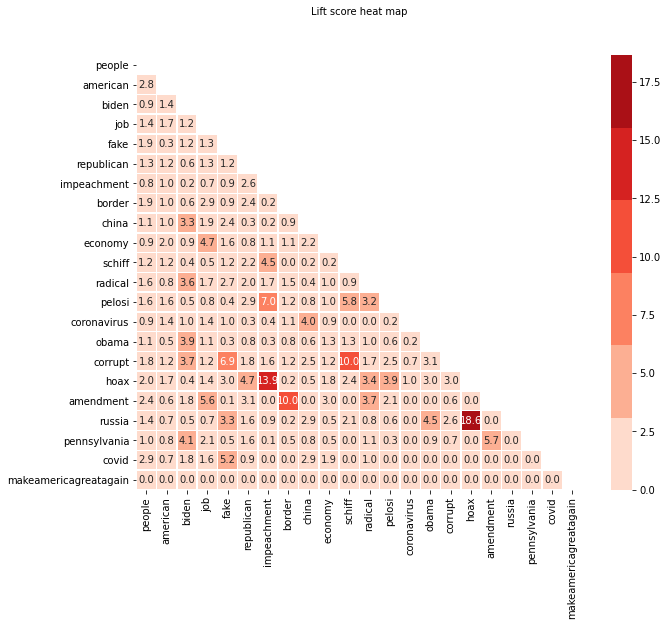

In [64]:
#Lift Analysis of Presidential Run (2019-2020)
matrix.index=words
matrix.columns=words
matrix.fillna(0, inplace=True)

mask = np.triu(np.ones_like(matrix))
colormap= sns.color_palette("Reds")

plt.figure(figsize=(10,8))
plt.title('Lift score heat map', fontsize = 10, pad = 40)
sns.heatmap(matrix, linewidths=0.5, annot=True, fmt=".1f", annot_kws={"fontsize":10},cmap=colormap,mask=mask)

In [65]:
dis_matrix.index=words
dis_matrix.columns=words
dis_matrix


,people,american,biden,job,fake,republican,impeachment,border,china,economy,...,pelosi,coronavirus,obama,corrupt,hoax,amendment,russia,pennsylvania,covid,makeamericagreatagain
people,NaN,0.360023,1.10363,0.700585,0.528958,0.748553,1.220157,0.525941,0.890385,1.114057,...,0.621811,1.11574,0.88872,0.543596,0.490745,0.424122,0.703937,1.023055,0.346102,0.0
american,0.360023,NaN,0.70906,0.580217,2.894442,0.825021,0.97115,1.033104,1.001499,0.491964,...,0.628159,0.740035,1.945219,0.839869,0.596742,1.768214,1.41237,1.244027,1.515088,0.0
biden,1.10363,0.70906,NaN,0.839872,0.847955,1.661468,4.119561,1.726387,0.300385,1.121436,...,2.099392,1.046395,0.259306,0.26765,2.255196,0.556867,2.033373,0.245718,0.545314,0.0
job,0.700585,0.580217,0.839872,NaN,0.748951,0.750804,1.533079,0.346729,0.514388,0.211153,...,1.207434,0.696843,0.903948,0.829365,0.727932,0.179745,1.531442,0.479217,0.616057,0.0
fake,0.528958,2.894442,0.847955,0.748951,NaN,0.80435,1.171292,1.145325,0.419269,0.62384,...,2.507014,0.961204,2.985949,0.144189,0.331659,9.49985,0.299037,2.148306,0.193807,0.0
republican,0.748553,0.825021,1.661468,0.750804,0.80435,NaN,0.379632,0.410989,3.530576,1.248183,...,0.342712,2.989296,1.269901,0.551901,0.214038,0.32466,0.638335,0.632532,1.112735,0.0
impeachment,1.220157,0.97115,4.119561,1.533079,1.171292,0.379632,NaN,5.434852,4.863309,0.872902,...,0.143676,2.470624,3.148681,0.619048,0.071761,0.0,1.143086,6.796163,0.0,0.0
border,0.525941,1.033104,1.726387,0.346729,1.145325,0.410989,5.434852,NaN,1.111674,0.951099,...,0.830905,0.920325,1.319519,0.807099,6.3755,0.099954,5.748401,1.898714,0.0,0.0
china,0.890385,1.001499,0.300385,0.514388,0.419269,3.530576,4.863309,1.111674,NaN,0.447936,...,1.239209,0.247062,1.771133,0.40625,1.901679,0.0,0.342926,1.274281,0.344874,0.0
economy,1.114057,0.491964,1.121436,0.211153,0.62384,1.248183,0.872902,0.951099,0.447936,NaN,...,0.963829,1.152958,0.78717,0.842593,0.554656,0.33713,2.0004,1.982214,0.536471,0.0


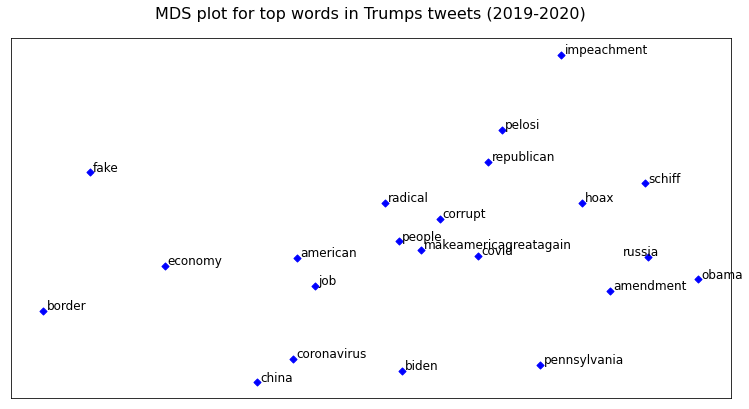

In [66]:
#MDS Plot
dis_matrix.index=words
dis_matrix.columns=words

dis_matrix=dis_matrix.fillna(0)
mdsmatrix= dis_matrix.values

mds=manifold.MDS(n_components=2, dissimilarity ='precomputed', random_state=10)

results=mds.fit(mdsmatrix)
coords=results.embedding_

x=coords[:,0]
y=coords[:,1]

plt.figure(figsize=(10,5)) 


ax=plt.axes([0.,0.,1.,1.])
plt.title('MDS plot for top words in Trumps tweets (2019-2020)', fontsize = 16, pad = 20)
plt.scatter(x, y, marker='D', color='blue', s = 25)

n=list(dis_matrix.index)

for i in range(len(n)):
    if n[i] == 'russia':
        ax.annotate(n[i], xy= (x[i] - 0.08, y[i] + 0.01), fontsize = 12)
    else:
        ax.annotate(n[i], xy = (x[i] + 0.01, y[i] + 0.01), fontsize = 12)


plt.xticks([])
plt.yticks([])
plt.show()

We asked ourselves the Question: What if Trump wants to run for 2024 elections. What should be his approach? What topics should he talk about? From the analysis of past 2015 and 2019 Election Campaigns, what is successful and what not?

For that, we scraped twitter data using Tweepy and tried to gain the sentiment of tweets mentioning Donald Trump and try to get the topic people are talking about so that he can address those.

## Tweet Scraping

In [71]:
#!pip install gensim
import tweepy
import pandas as pd
pd.set_option("display.max_colwidth", 10000)
import time

import nltk
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
from bs4 import BeautifulSoup

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from collections import Counter

from gensim.models import Word2Vec
import numpy as np
import random
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

#Twitter API authorisation
consumer_key = "***************"
consumer_secret = "*************"

access_token = "**************"
access_token_secret = "************"

authorization = tweepy.OAuthHandler(consumer_key, consumer_secret)

authorization.set_access_token(access_token, access_token_secret)

api = tweepy.API(authorization,wait_on_rate_limit=True)

In [ ]:
#Scraping the tweets
count = 2000

try:
    #Filter search with 'dogs' term and also remove all retweets, only English
    tweets_obj = tweepy.Cursor(api.search_tweets,q="The Donald Trump -filter:retweets & -filter:replies", lang = "en", tweet_mode='extended').items(count)
    tweets_list = [[tweet.created_at, tweet.id, tweet.full_text] for tweet in tweets_obj]
    tweets_df = pd.DataFrame(tweets_list)
    print("Number of tweets = {}".format(len(tweets_df)))

except BaseException as e:

    print("something went wrong, ",str(e))

In [ ]:
tweets_df_final = tweets_df_1.append(tweets_df_2)
tweets_df_fin = tweets_df_final.append(tweets_df)
tweets_df_fin.shape
tweets_df_fin.to_csv("/Users/muskaansinghania/Downloads/trump_tweets_finale.csv")

In [95]:
trumpCurrentDf = pd.read_csv("trump_tweets_finale.csv")
trumpCurrentDf

,Date,ID,post
0,2022-10-16 22:51:11+00:00,1.581780e+18,He’s just disgusting \nhttps://t.co/8kyc8Bb7FE
1,2022-10-16 22:51:10+00:00,1.581780e+18,"1/Why are Dems waving the flag of surrender on the economy?https://t.co/PCBjgGJ4to\n\n""Yes world-wide inflation is high bc Covid &amp; Putin's war but Biden increased job growth 500%, pulled us out of Trump's deep recession, rescued millions of kids from poverty""\n\nGOP plan? Raise cost$"
2,2022-10-16 22:51:09+00:00,1.581780e+18,Raw Story: New York AG's Trump case reveals he had a huge breakup with one of the last banks that'll work with him.\nhttps://t.co/rcOdtUxwai\n\nvia @GoogleNews
3,2022-10-16 22:51:04+00:00,1.581780e+18,"I don’t see any attack on his comment, but I see an attack from this media against Trump making this information sensationalist, as a Jewish I only see a huge truth in his words, Washington Post mostly publishing fake news… https://t.co/1YtZRrkK47"
4,2022-10-16 22:51:04+00:00,1.581780e+18,Trump blasted for telling American Jews to ‘get their act together’ #SmartNews https://t.co/cZZXYa8oNZ
...,...,...,...
5995,2022-10-16 14:01:51+00:00,1.581650e+18,Doug Mastriano tried to disqualify his own state's votes in the 2020 election and refuses to disclose who he would appoint to run Pennsylvania's elections. #pagov \n\nhttps://t.co/p1rlKe0IPS
5996,2022-10-16 14:01:50+00:00,1.581650e+18,"As Trump fueled polarization in the U.S., he was having a much different impact on Canada; a cultural sociological perspective helps explain why. https://t.co/8GG6LuUgSl"
5997,2022-10-16 14:01:27+00:00,1.581650e+18,Someone take these stitches OUTTA ME i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu.
5998,2022-10-16 14:01:22+00:00,1.581650e+18,Get over Trump: Obama takes aim at Dems over Donald obsession ahead of midterms https://t.co/OrwCmUS19D Absolutely so agree! Stop letting the pig scum clld Don take up free rent in ur head! He will never be reelected so time to move on from this Con Job!


In [100]:
import re

trumpCurrentDf['post'] = trumpCurrentDf['post'].map(lambda x : re.sub('http(s)?\S+','',x))

trumpCurrentDf['Tweet_Tokens'] = trumpCurrentDf['post'].map(lambda x : re.sub('(@[a-zA-z]+)|([!\"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#]+)','',x))

#Removing extra lines
trumpCurrentDf['Tweet_Tokens'] = trumpCurrentDf['Tweet_Tokens'].map(lambda x: re.sub('\n',' ',x))
#Removing additional spaces and converting to lower case
trumpCurrentDf['Tweet_Tokens'] = trumpCurrentDf['Tweet_Tokens'].map(lambda x: re.sub("\\s+",' ',x.strip().lower()))


In [101]:
trumpCurrentDf['Tweet_Tokens'] = trumpCurrentDf['Tweet_Tokens'].map(lambda x: remove_emojis(x))
trumpCurrentDf

,Date,ID,post,Tweet_Tokens
0,2022-10-16 22:51:11+00:00,1.581780e+18,He’s just disgusting \n,he’s just disgusting
1,2022-10-16 22:51:10+00:00,1.581780e+18,"1/Why are Dems waving the flag of surrender on the economy?\n\n""Yes world-wide inflation is high bc Covid &amp; Putin's war but Biden increased job growth 500%, pulled us out of Trump's deep recession, rescued millions of kids from poverty""\n\nGOP plan? Raise cost$",1why are dems waving the flag of surrender on the economy yes worldwide inflation is high bc covid amp putins war but biden increased job growth 500 pulled us out of trumps deep recession rescued millions of kids from poverty gop plan raise cost
2,2022-10-16 22:51:09+00:00,1.581780e+18,Raw Story: New York AG's Trump case reveals he had a huge breakup with one of the last banks that'll work with him.\n\n\nvia @GoogleNews,raw story new york ags trump case reveals he had a huge breakup with one of the last banks thatll work with him via
3,2022-10-16 22:51:04+00:00,1.581780e+18,"I don’t see any attack on his comment, but I see an attack from this media against Trump making this information sensationalist, as a Jewish I only see a huge truth in his words, Washington Post mostly publishing fake news…",i don’t see any attack on his comment but i see an attack from this media against trump making this information sensationalist as a jewish i only see a huge truth in his words washington post mostly publishing fake news…
4,2022-10-16 22:51:04+00:00,1.581780e+18,Trump blasted for telling American Jews to ‘get their act together’ #SmartNews,trump blasted for telling american jews to ‘get their act together’ smartnews
...,...,...,...,...
5995,2022-10-16 14:01:51+00:00,1.581650e+18,Doug Mastriano tried to disqualify his own state's votes in the 2020 election and refuses to disclose who he would appoint to run Pennsylvania's elections. #pagov \n\n,doug mastriano tried to disqualify his own states votes in the 2020 election and refuses to disclose who he would appoint to run pennsylvanias elections pagov
5996,2022-10-16 14:01:50+00:00,1.581650e+18,"As Trump fueled polarization in the U.S., he was having a much different impact on Canada; a cultural sociological perspective helps explain why.",as trump fueled polarization in the us he was having a much different impact on canada a cultural sociological perspective helps explain why
5997,2022-10-16 14:01:27+00:00,1.581650e+18,Someone take these stitches OUTTA ME i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu.,someone take these stitches outta me i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu
5998,2022-10-16 14:01:22+00:00,1.581650e+18,Get over Trump: Obama takes aim at Dems over Donald obsession ahead of midterms Absolutely so agree! Stop letting the pig scum clld Don take up free rent in ur head! He will never be reelected so time to move on from this Con Job!,get over trump obama takes aim at dems over donald obsession ahead of midterms absolutely so agree stop letting the pig scum clld don take up free rent in ur head he will never be reelected so time to move on from this con job


In [103]:
## Tokenize the tweets

from nltk.tokenize import word_tokenize
trumpCurrentDf['tokenized_words'] = trumpCurrentDf['Tweet_Tokens'].map(lambda x: word_tokenize(x))
trumpCurrentDf


,Date,ID,post,Tweet_Tokens,tokenized_words
0,2022-10-16 22:51:11+00:00,1.581780e+18,He’s just disgusting \n,he’s just disgusting,"[he, ’, s, just, disgusting]"
1,2022-10-16 22:51:10+00:00,1.581780e+18,"1/Why are Dems waving the flag of surrender on the economy?\n\n""Yes world-wide inflation is high bc Covid &amp; Putin's war but Biden increased job growth 500%, pulled us out of Trump's deep recession, rescued millions of kids from poverty""\n\nGOP plan? Raise cost$",1why are dems waving the flag of surrender on the economy yes worldwide inflation is high bc covid amp putins war but biden increased job growth 500 pulled us out of trumps deep recession rescued millions of kids from poverty gop plan raise cost,"[1why, are, dems, waving, the, flag, of, surrender, on, the, economy, yes, worldwide, inflation, is, high, bc, covid, amp, putins, war, but, biden, increased, job, growth, 500, pulled, us, out, of, trumps, deep, recession, rescued, millions, of, kids, from, poverty, gop, plan, raise, cost]"
2,2022-10-16 22:51:09+00:00,1.581780e+18,Raw Story: New York AG's Trump case reveals he had a huge breakup with one of the last banks that'll work with him.\n\n\nvia @GoogleNews,raw story new york ags trump case reveals he had a huge breakup with one of the last banks thatll work with him via,"[raw, story, new, york, ags, trump, case, reveals, he, had, a, huge, breakup, with, one, of, the, last, banks, thatll, work, with, him, via]"
3,2022-10-16 22:51:04+00:00,1.581780e+18,"I don’t see any attack on his comment, but I see an attack from this media against Trump making this information sensationalist, as a Jewish I only see a huge truth in his words, Washington Post mostly publishing fake news…",i don’t see any attack on his comment but i see an attack from this media against trump making this information sensationalist as a jewish i only see a huge truth in his words washington post mostly publishing fake news…,"[i, don, ’, t, see, any, attack, on, his, comment, but, i, see, an, attack, from, this, media, against, trump, making, this, information, sensationalist, as, a, jewish, i, only, see, a, huge, truth, in, his, words, washington, post, mostly, publishing, fake, news…]"
4,2022-10-16 22:51:04+00:00,1.581780e+18,Trump blasted for telling American Jews to ‘get their act together’ #SmartNews,trump blasted for telling american jews to ‘get their act together’ smartnews,"[trump, blasted, for, telling, american, jews, to, ‘, get, their, act, together, ’, smartnews]"
...,...,...,...,...,...
5995,2022-10-16 14:01:51+00:00,1.581650e+18,Doug Mastriano tried to disqualify his own state's votes in the 2020 election and refuses to disclose who he would appoint to run Pennsylvania's elections. #pagov \n\n,doug mastriano tried to disqualify his own states votes in the 2020 election and refuses to disclose who he would appoint to run pennsylvanias elections pagov,"[doug, mastriano, tried, to, disqualify, his, own, states, votes, in, the, 2020, election, and, refuses, to, disclose, who, he, would, appoint, to, run, pennsylvanias, elections, pagov]"
5996,2022-10-16 14:01:50+00:00,1.581650e+18,"As Trump fueled polarization in the U.S., he was having a much different impact on Canada; a cultural sociological perspective helps explain why.",as trump fueled polarization in the us he was having a much different impact on canada a cultural sociological perspective helps explain why,"[as, trump, fueled, polarization, in, the, us, he, was, having, a, much, different, impact, on, canada, a, cultural, sociological, perspective, helps, explain, why]"
5997,2022-10-16 14:01:27+00:00,1.581650e+18,Someone take these stitches OUTTA ME i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu.,someone take these stitches outta me i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu,"[someone, take,

In [104]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')

necessary_removal=['link','amp','quot','rt']

stopwords.extend(necessary_removal)

#removing stopwords and retweet label from the words

trumpCurrentDf['tokenized_words'] = trumpCurrentDf['tokenized_words'].map(lambda x: [item for item in x if item not in stopwords])

lemmatizer = WordNetLemmatizer()
#Get root form of the word
trumpCurrentDf['tokenized_words'] = trumpCurrentDf['tokenized_words'].map(lambda x: [lemmatizer.lemmatize(item) for item in x])


trumpCurrentDf

,Date,ID,post,Tweet_Tokens,tokenized_words
0,2022-10-16 22:51:11+00:00,1.581780e+18,He’s just disgusting \n,he’s just disgusting,"[’, disgusting]"
1,2022-10-16 22:51:10+00:00,1.581780e+18,"1/Why are Dems waving the flag of surrender on the economy?\n\n""Yes world-wide inflation is high bc Covid &amp; Putin's war but Biden increased job growth 500%, pulled us out of Trump's deep recession, rescued millions of kids from poverty""\n\nGOP plan? Raise cost$",1why are dems waving the flag of surrender on the economy yes worldwide inflation is high bc covid amp putins war but biden increased job growth 500 pulled us out of trumps deep recession rescued millions of kids from poverty gop plan raise cost,"[1why, dems, waving, flag, surrender, economy, yes, worldwide, inflation, high, bc, covid, putin, war, biden, increased, job, growth, 500, pulled, u, trump, deep, recession, rescued, million, kid, poverty, gop, plan, raise, cost]"
2,2022-10-16 22:51:09+00:00,1.581780e+18,Raw Story: New York AG's Trump case reveals he had a huge breakup with one of the last banks that'll work with him.\n\n\nvia @GoogleNews,raw story new york ags trump case reveals he had a huge breakup with one of the last banks thatll work with him via,"[raw, story, new, york, ag, trump, case, reveals, huge, breakup, one, last, bank, thatll, work, via]"
3,2022-10-16 22:51:04+00:00,1.581780e+18,"I don’t see any attack on his comment, but I see an attack from this media against Trump making this information sensationalist, as a Jewish I only see a huge truth in his words, Washington Post mostly publishing fake news…",i don’t see any attack on his comment but i see an attack from this media against trump making this information sensationalist as a jewish i only see a huge truth in his words washington post mostly publishing fake news…,"[’, see, attack, comment, see, attack, medium, trump, making, information, sensationalist, jewish, see, huge, truth, word, washington, post, mostly, publishing, fake, news…]"
4,2022-10-16 22:51:04+00:00,1.581780e+18,Trump blasted for telling American Jews to ‘get their act together’ #SmartNews,trump blasted for telling american jews to ‘get their act together’ smartnews,"[trump, blasted, telling, american, jew, ‘, get, act, together, ’, smartnews]"
...,...,...,...,...,...
5995,2022-10-16 14:01:51+00:00,1.581650e+18,Doug Mastriano tried to disqualify his own state's votes in the 2020 election and refuses to disclose who he would appoint to run Pennsylvania's elections. #pagov \n\n,doug mastriano tried to disqualify his own states votes in the 2020 election and refuses to disclose who he would appoint to run pennsylvanias elections pagov,"[doug, mastriano, tried, disqualify, state, vote, 2020, election, refuse, disclose, would, appoint, run, pennsylvania, election, pagov]"
5996,2022-10-16 14:01:50+00:00,1.581650e+18,"As Trump fueled polarization in the U.S., he was having a much different impact on Canada; a cultural sociological perspective helps explain why.",as trump fueled polarization in the us he was having a much different impact on canada a cultural sociological perspective helps explain why,"[trump, fueled, polarization, u, much, different, impact, canada, cultural, sociological, perspective, help, explain]"
5997,2022-10-16 14:01:27+00:00,1.581650e+18,Someone take these stitches OUTTA ME i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu.,someone take these stitches outta me i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu,"[someone, take, stitch, outta, ’, tired, donald, trump, never, thrown, actual, bear, seem, like, ’, still, want, fly, ice, one, take, make, qu]"
5998,2022-10-16 14:01:22+00:00,1.581650e+18,Get over Trump: Obama takes aim at Dems over Donald obsession ahead of midterms Absolutely so agree! Stop letting the pig scum clld Don take up fr

In [105]:
trumpCurrentDf['vader_score'] = trumpCurrentDf['tokenized_words'].apply(lambda x: vaderScore(x))
trumpCurrentDf['sentiment'],trumpCurrentDf['compound_score'] = zip(*trumpCurrentDf['vader_score'])
trumpCurrentDf

,Date,ID,post,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score
0,2022-10-16 22:51:11+00:00,1.581780e+18,He’s just disgusting \n,he’s just disgusting,"[’, disgusting]","(Negative, -0.5267)",Negative,-0.5267
1,2022-10-16 22:51:10+00:00,1.581780e+18,"1/Why are Dems waving the flag of surrender on the economy?\n\n""Yes world-wide inflation is high bc Covid &amp; Putin's war but Biden increased job growth 500%, pulled us out of Trump's deep recession, rescued millions of kids from poverty""\n\nGOP plan? Raise cost$",1why are dems waving the flag of surrender on the economy yes worldwide inflation is high bc covid amp putins war but biden increased job growth 500 pulled us out of trumps deep recession rescued millions of kids from poverty gop plan raise cost,"[1why, dems, waving, flag, surrender, economy, yes, worldwide, inflation, high, bc, covid, putin, war, biden, increased, job, growth, 500, pulled, u, trump, deep, recession, rescued, million, kid, poverty, gop, plan, raise, cost]","(Negative, -0.2023)",Negative,-0.2023
2,2022-10-16 22:51:09+00:00,1.581780e+18,Raw Story: New York AG's Trump case reveals he had a huge breakup with one of the last banks that'll work with him.\n\n\nvia @GoogleNews,raw story new york ags trump case reveals he had a huge breakup with one of the last banks thatll work with him via,"[raw, story, new, york, ag, trump, case, reveals, huge, breakup, one, last, bank, thatll, work, via]","(Neutral, 0.3182)",Neutral,0.3182
3,2022-10-16 22:51:04+00:00,1.581780e+18,"I don’t see any attack on his comment, but I see an attack from this media against Trump making this information sensationalist, as a Jewish I only see a huge truth in his words, Washington Post mostly publishing fake news…",i don’t see any attack on his comment but i see an attack from this media against trump making this information sensationalist as a jewish i only see a huge truth in his words washington post mostly publishing fake news…,"[’, see, attack, comment, see, attack, medium, trump, making, information, sensationalist, jewish, see, huge, truth, word, washington, post, mostly, publishing, fake, news…]","(Negative, -0.6908)",Negative,-0.6908
4,2022-10-16 22:51:04+00:00,1.581780e+18,Trump blasted for telling American Jews to ‘get their act together’ #SmartNews,trump blasted for telling american jews to ‘get their act together’ smartnews,"[trump, blasted, telling, american, jew, ‘, get, act, together, ’, smartnews]","(Neutral, 0.0)",Neutral,0.0000
...,...,...,...,...,...,...,...,...
5995,2022-10-16 14:01:51+00:00,1.581650e+18,Doug Mastriano tried to disqualify his own state's votes in the 2020 election and refuses to disclose who he would appoint to run Pennsylvania's elections. #pagov \n\n,doug mastriano tried to disqualify his own states votes in the 2020 election and refuses to disclose who he would appoint to run pennsylvanias elections pagov,"[doug, mastriano, tried, disqualify, state, vote, 2020, election, refuse, disclose, would, appoint, run, pennsylvania, election, pagov]","(Negative, -0.296)",Negative,-0.2960
5996,2022-10-16 14:01:50+00:00,1.581650e+18,"As Trump fueled polarization in the U.S., he was having a much different impact on Canada; a cultural sociological perspective helps explain why.",as trump fueled polarization in the us he was having a much different impact on canada a cultural sociological perspective helps explain why,"[trump, fueled, polarization, u, much, different, impact, canada, cultural, sociological, perspective, help, explain]","(Neutral, 0.4019)",Neutral,0.4019
5997,2022-10-16 14:01:27+00:00,1.581650e+18,Someone take these stitches OUTTA ME i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu.,someone take these stitches outta me i’m tired of donald trump has never thrown an actual bear seem like you’d still want to be a fly on the ice no one does it take to make me qu,"[someone, take, stitch, outta

<AxesSubplot:title={'center':'Sentiment of Current Times'}, ylabel='Tweet Count'>

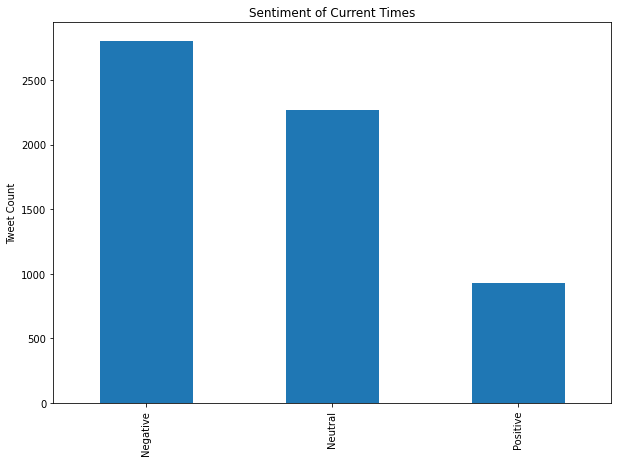

In [108]:
trumpCurrentDf[['post', 'Tweet_Tokens', 'tokenized_words', 'vader_score', 'sentiment', 'compound_score']]

trumpCurrentDf['sentiment'].value_counts().plot(kind='bar',title='Sentiment of Current Times',ylabel='Tweet Count')

## Positive Sentiment Tweet Analysis

In [123]:
trumpTweetsDf_pos = trumpCurrentDf[trumpCurrentDf['sentiment'] == 'Positive' ]
message_text = [word for one_message in trumpCurrentDf['tokenized_words'] for word in one_message]
hundred_most_common_words = Counter(message_text).most_common(100)

In [124]:
#Initializing Required Variables
base_df = trumpTweetsDf_pos.copy()
top_att = ['Jew', 'truth', 'israel', 'attack', 'law', 'cohen', 'smartnews', 'evangelicals','election', 'maga', 'vote', '2020', '2024']
prez = 'trump'
lift_table = pd.DataFrame(columns = top_att)
base_df["word_unique"] = base_df["tokenized_words"].apply(lambda x: sorted(set(x)))

In [125]:
def lift_analysis(a, b, message_tokens):
    freq_a = 0
    freq_b = 0
    freq_a_b = 0
    n = len(message_tokens)
    for i in message_tokens:
        if any(i in a for i in i):
            freq_a += 1
        if b in i:
            freq_b += 1
        if any(i in a for i in i) and b in i:
            freq_a_b += 1
    if freq_a == 0:
        return (float(n)*freq_a_b)/(freq_b)
    elif freq_b == 0:
        return (float(n)*freq_a_b)/(freq_a)
    else:
        return (float(n)*freq_a_b)/(freq_a*freq_b)

In [126]:
prez_att_lift =pd.DataFrame(columns=['Trump','Topic','lift'])
i=0
for att in top_att:
    temp_lift=lift_analysis(prez.lower(), str(att).lower(), base_df.word_unique)
    prez_att_lift.loc[i]=[prez.lower(), str(att).lower(),temp_lift]
    i=i+1

In [127]:
df_temp = prez_att_lift.sort_values('lift',ascending = False)
df_temp

,Trump,Topic,lift
2,trump,israel,1.066820
3,trump,attack,1.066820
5,trump,cohen,1.066820
6,trump,smartnews,1.066820
7,trump,evangelicals,1.066820
9,trump,maga,1.066820
11,trump,2020,1.066820
12,trump,2024,1.066820
1,trump,truth,1.058614
0,trump,jew,1.054120


### Negetive Sentiment Tweet Analysis

In [128]:
trumpTweetsDf_neg = trumpCurrentDf[trumpCurrentDf['sentiment'] == 'Negative' ]
base_df = trumpTweetsDf_neg.copy()
top_att = ['Jew', 'truth', 'israel', 'attack', 'law', 'cohen', 'smartnews', 'evangelicals','election', 'maga', 'vote', '2020', '2024']
prez = 'trump'
lift_table = pd.DataFrame(columns = top_att)
base_df["word_unique"] = base_df["tokenized_words"].apply(lambda x: sorted(set(x)))

In [129]:
prez_att_lift =pd.DataFrame(columns=['Trump','Topic','lift'])
i=0
for att in top_att:
    temp_lift=lift_analysis(prez.lower(), str(att).lower(), base_df.word_unique)
    prez_att_lift.loc[i]=[prez.lower(), str(att).lower(),temp_lift]
    i=i+1

In [130]:
df_temp = prez_att_lift.sort_values('lift',ascending = False)
df_temp

,Trump,Topic,lift
5,trump,cohen,1.096951
3,trump,attack,1.088313
11,trump,2020,1.087412
2,trump,israel,1.086504
0,trump,jew,1.083695
7,trump,evangelicals,1.072574
12,trump,2024,1.065609
4,trump,law,1.059555
6,trump,smartnews,1.053933
9,trump,maga,1.012570


### Hashtag Analysis of Positive and Negetive Sentiment Tweets

In [131]:
trumpTweetsDf_pos['hashtag'] = trumpTweetsDf_pos['post'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #Extract hashtags

<ipython-input-131-499c586873e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trumpTweetsDf_pos['hashtag'] = trumpTweetsDf_pos['post'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #Extract hashtags


In [132]:
trumpTweetsDf_pos

,Date,ID,post,Tweet_Tokens,tokenized_words,vader_score,sentiment,compound_score,hashtag
8,2022-10-16 22:50:58+00:00,1.581780e+18,Anyone got good links to compilation videos of trump’s funniest lines? Dude sure has a way with words,anyone got good links to compilation videos of trump’s funniest lines dude sure has a way with words,"[anyone, got, good, link, compilation, video, trump, ’, funniest, line, dude, sure, way, word]","(Positive, 0.8316)",Positive,0.8316,[]
11,2022-10-16 22:50:55+00:00,1.581780e+18,"When Trump had ""two"" scoops of ice cream it was an impeachable offense, but Biden's two scoops are great.",when trump had two scoops of ice cream it was an impeachable offense but bidens two scoops are great,"[trump, two, scoop, ice, cream, impeachable, offense, bidens, two, scoop, great]","(Positive, 0.6486)",Positive,0.6486,[]
15,2022-10-16 22:50:46+00:00,1.581780e+18,"She's telling people that no matter what, she's winning. So stay home, she's winning. For democracy, I ask democrats to vote, show that voting is your choice, not Arizona dictatorship. Vote democrats. Republicans, stay home and just 🤔 think about life with Trump in power. 🤔",shes telling people that no matter what shes winning so stay home shes winning for democracy i ask democrats to vote show that voting is your choice not arizona dictatorship vote democrats republicans stay home and just think about life with trump in power,"[shes, telling, people, matter, shes, winning, stay, home, shes, winning, democracy, ask, democrat, vote, show, voting, choice, arizona, dictatorship, vote, democrat, republican, stay, home, think, life, trump, power]","(Positive, 0.7845)",Positive,0.7845,[]
17,2022-10-16 22:50:46+00:00,1.581780e+18,Musk has a ‘super app’ plan for Twitter. It’s super vague\n\n(Just go away Petulant Musk stink. Stop trying to be a Trump and break things.)\n#Twitter #ElonMusk \n,musk has a ‘super app’ plan for twitter it’s super vague just go away petulant musk stink stop trying to be a trump and break things twitter elonmusk,"[musk, ‘, super, app, ’, plan, twitter, ’, super, vague, go, away, petulant, musk, stink, stop, trying, trump, break, thing, twitter, elonmusk]","(Positive, 0.5423)",Positive,0.5423,"[#Twitter, #ElonMusk]"
20,2022-10-16 22:50:38+00:00,1.581780e+18,"Beltway Insider: Biden/Nat'l Security, Midterms, Jan 6/Trump, Florida, Social Security, COVID/Vaccine Totals, Raleigh, Parkland, Angela Lansbury",beltway insider bidennatl security midterms jan 6trump florida social security covidvaccine totals raleigh parkland angela lansbury,"[beltway, insider, bidennatl, security, midterm, jan, 6trump, florida, social, security, covidvaccine, total, raleigh, parkland, angela, lansbury]","(Positive, 0.5859)",Positive,0.5859,[]
...,...,...,...,...,...,...,...,...,...
5971,2022-10-16 14:08:59+00:00,1.581650e+18,"#MasonResearch Ilya Somin of @georgemasonlaw is quoted in this piece: The Supreme Court, for Now, Is Playing a Central Role in Discrediting Donald Trump",masonresearch ilya somin of is quoted in this piece the supreme court for now is playing a central role in discrediting donald trump,"[masonresearch, ilya, somin, quoted, piece, supreme, court, playing, central, role, discrediting, donald, trump]","(Positive, 0.6597)",Positive,0.6597,[#MasonResearch]
5976,2022-10-16 14:06:56+00:00,1.581650e+18,"and when Donald Trump, bless his heart, said ""build the wall,""",and when donald trump bless his heart said build the wall,"[donald, trump, bless, heart, said, build, wall]","(Positive, 0.7906)",Positive,0.7906,[]
5979,2022-10-16 14:06:17+00:00,1.581650e+18,"A co-founder of Trump Media &amp; Technology Group, the company behind Truth Social, said former President Donald Trump pushed another executive to give some of his shares to Melania Trump and retaliated when the request was declined, according to a Washington Post report.",a cofounder of trump media amp technology group the company behind truth social said former president donald trump pushed ano

In [133]:
hashtags_list_pos=[]
trumpTweetsDf_pos.hashtag.apply(lambda x: hashtags_list_pos.extend(x))
unique_hashtags=list(set(hashtags_list_pos))
len(unique_hashtags)

157

<AxesSubplot:>

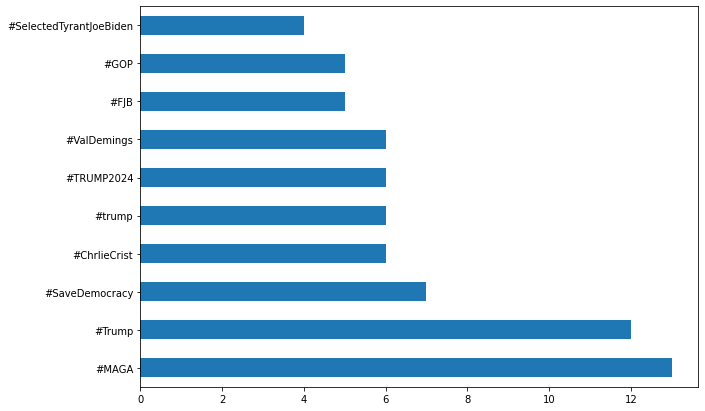

In [134]:
pd.Series(hashtags_list_pos).value_counts()[:10].plot(kind="barh")

In [135]:
trumpTweetsDf_neg['hashtag'] = trumpTweetsDf_neg['post'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #Extract hashtags

<ipython-input-135-74a3f15b1635>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trumpTweetsDf_neg['hashtag'] = trumpTweetsDf_neg['post'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #Extract hashtags


In [136]:
hashtags_list_neg=[]
trumpTweetsDf_neg.hashtag.apply(lambda x: hashtags_list_neg.extend(x))
unique_hashtags=list(set(hashtags_list_neg))
len(unique_hashtags)

472

<AxesSubplot:>

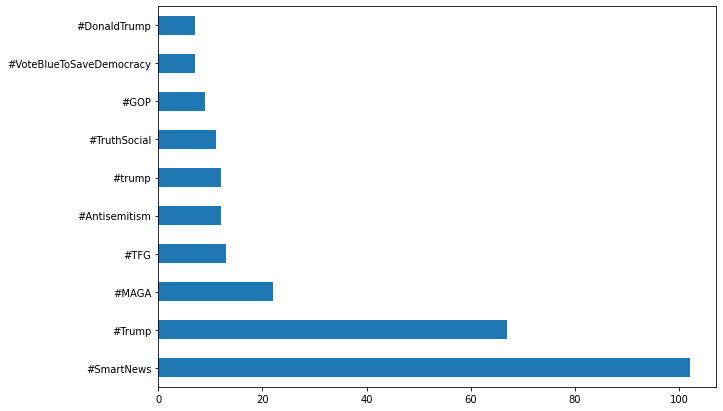

In [137]:
pd.Series(hashtags_list_neg).value_counts()[:10].plot(kind="barh")